In [299]:
%matplotlib inline

In [300]:
# for internal notebook use ref:jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

In [3]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

In [4]:
file_to_load = "data/us_perm_visas.csv"
#after inital inspecting went back to parse for dates
csv_data = pd.read_csv(file_to_load, low_memory = False, parse_dates=['decision_date', 'case_received_date'])
csv_data.columns

Index(['add_these_pw_job_title_9089', 'agent_city', 'agent_firm_name',
       'agent_state', 'application_type', 'case_no', 'case_number',
       'case_received_date', 'case_status', 'class_of_admission',
       ...
       'ri_pvt_employment_firm_to', 'ri_us_workers_considered',
       'schd_a_sheepherder', 'us_economic_sector', 'wage_offer_from_9089',
       'wage_offer_to_9089', 'wage_offer_unit_of_pay_9089',
       'wage_offered_from_9089', 'wage_offered_to_9089',
       'wage_offered_unit_of_pay_9089'],
      dtype='object', length=154)

In [7]:
# pd.set_option('display.max_rows', 154)
# csv_data.count()

In [5]:
#Inspecting case status shows very low denied and wrathdrawn cases
print(csv_data['case_status'].value_counts())
deny_percent = round((((csv_data['case_status']=='Denied').sum())/(((csv_data['case_status']=='Certified').sum())+((csv_data['case_status']=='Certified-Expired').sum())))*100, 2)
print("")
print("Only {}% of Applicants were denied".format(deny_percent))

Certified            181933
Certified-Expired    148586
Denied                25649
Withdrawn             18194
Name: case_status, dtype: int64

Only 7.76% of Applicants were denied


In [6]:
#Counts show large number of rows with missing data, Before we start cleaning data we can already use matplot to visualize denial rates over years:
#Converting the date to contain just the year of application submission
csv_data['year'] = csv_data['decision_date'].dt.year
#Drop withdrawn case status from dataset, as it is applicant dependant and as such cannot be quantifiable making data immiscible 
csv_data = csv_data[csv_data['case_status'] != 'Withdrawn']
#Combine case status "Certified" and "Certified-Expired" since the latter simply requires an additional document to be signed upon landing as per internet sources 
csv_data['case_status'] = csv_data['case_status'].replace('Certified-Expired', 'Certified')
csv_data['case_status'].value_counts()

Certified    330519
Denied        25649
Name: case_status, dtype: int64

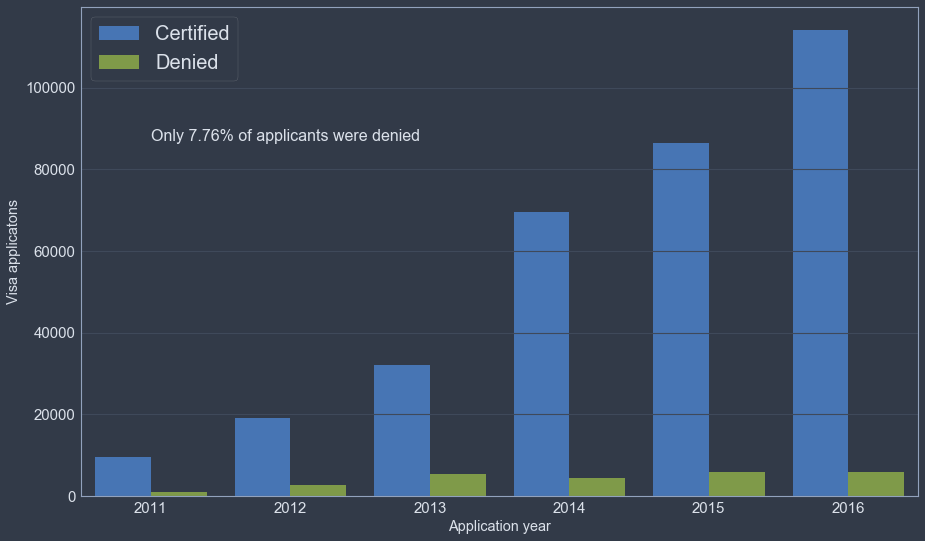

In [10]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sb.set_context(rc={"font.size":16})
sb.countplot(x="year", hue="case_status", data=csv_data)
ax.set(xlabel='Application year', ylabel='Visa applicatons')
ax.text(0,87000, f"Only {deny_percent}% of applicants were denied")
ax.tick_params(labelsize=15)
plt.legend(loc=2, prop={'size': 20})
plt.savefig("output/images/case_status.png", bbox_inches='tight')

In [ ]:
# Unfortunately all other columns are a mess with multiple duplicate fields so its time to get our cyber-hands dirty
# Columns to use: 
# For applicant info, we want country, educational background, and some info on decision time 
# For job info, we want educational requirements, location, wage, and name of company
# doing some value_counts() it can be determined that job title and major have way too many variances
# Naics titles are more generalized and as such a better way to display information, will use this instead of job title/major

In [7]:
useful_columns = [
    "case_received_date",
    "case_status",
    "decision_date",
    "employer_city",
    "employer_state",
    "employer_name",
    "country_of_citizenship",
    "country_of_citzenship",
    "foreign_worker_info_birth_country",
    "fw_info_birth_country",
    "foreign_worker_info_education",
    "job_info_education",
    "job_info_work_city",
    "job_info_work_state",
    "wage_offer_from_9089",
    "wage_offered_from_9089",
    "pw_amount_9089",
    "wage_offer_unit_of_pay_9089",
    "wage_offered_unit_of_pay_9089",
    "pw_unit_of_pay_9089",
    "naics_2007_us_title",
    "naics_us_title_2007",
    "naics_title",
    "naics_us_title",
    ]

useful_data = csv_data.loc[:, useful_columns]
useful_data.count()

case_received_date                   229320
case_status                          356168
decision_date                        356168
employer_city                        356158
employer_state                       356131
employer_name                        356160
country_of_citizenship               336896
country_of_citzenship                 19217
foreign_worker_info_birth_country     84288
fw_info_birth_country                145002
foreign_worker_info_education        229281
job_info_education                   229309
job_info_work_city                   356073
job_info_work_state                  356072
wage_offer_from_9089                 248463
wage_offered_from_9089               107586
pw_amount_9089                       353965
wage_offer_unit_of_pay_9089          247399
wage_offered_unit_of_pay_9089         66698
pw_unit_of_pay_9089                  354687
naics_2007_us_title                   18570
naics_us_title_2007                  104275
naics_title                     

In [8]:
# value_counts() determined certain columns share the same info
# country_of_citizenship holds same values as 3 other columns, overlap them while keeping country_of_citizenship values
useful_data['country_of_citizenship'] = np.where(useful_data['country_of_citizenship'].isna(),useful_data['fw_info_birth_country'], useful_data['country_of_citizenship'])
useful_data['country_of_citizenship'] = np.where(useful_data['country_of_citizenship'].isna(),useful_data['country_of_citzenship'], useful_data['country_of_citizenship'])
useful_data['country_of_citizenship'] = np.where(useful_data['country_of_citizenship'].isna(),useful_data['foreign_worker_info_birth_country'], useful_data['country_of_citizenship'])
useful_data['country_of_citizenship'].count()

356127

In [9]:
# now to overlap job city and state with employer city and state, keeping job_info_work_city values
useful_data['job_info_work_city'] = np.where(useful_data['job_info_work_city'].isna(),useful_data['employer_city'], useful_data['job_info_work_city'])
useful_data['job_info_work_state'] = np.where(useful_data['job_info_work_state'].isna(),useful_data['employer_state'], useful_data['job_info_work_state'])
print(useful_data['job_info_work_city'].count())
print(useful_data['job_info_work_state'].count())

356163
356162


In [10]:
useful_data['pw_amount_9089'] = np.where(useful_data['pw_amount_9089'].isna(),useful_data['wage_offer_from_9089'], useful_data['pw_amount_9089'])
useful_data['pw_amount_9089'] = np.where(useful_data['pw_amount_9089'].isna(),useful_data['wage_offered_from_9089'], useful_data['pw_amount_9089'])
useful_data['pw_amount_9089'].count()

356083

In [11]:
useful_data['pw_unit_of_pay_9089'] = np.where(useful_data['pw_unit_of_pay_9089'].isna(),useful_data['wage_offer_unit_of_pay_9089'], useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'] = np.where(useful_data['pw_unit_of_pay_9089'].isna(),useful_data['wage_offered_unit_of_pay_9089'], useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].count()

355016

In [12]:
useful_data['naics_us_title'] = np.where(useful_data['naics_us_title'].isna(),useful_data['naics_us_title_2007'], useful_data['naics_us_title'])
useful_data['naics_us_title'] = np.where(useful_data['naics_us_title'].isna(),useful_data['naics_title'], useful_data['naics_us_title'])
useful_data['naics_us_title'] = np.where(useful_data['naics_us_title'].isna(),useful_data['naics_2007_us_title'], useful_data['naics_us_title'])
useful_data['naics_us_title'].count()

351644

In [13]:
#drop columns that were overlapped
useful_data = useful_data.drop(['fw_info_birth_country', 'country_of_citzenship', 'foreign_worker_info_birth_country',
                                'employer_city', 'employer_state','wage_offered_from_9089','wage_offer_from_9089',
                                'wage_offer_unit_of_pay_9089','wage_offered_unit_of_pay_9089','naics_2007_us_title',
                                'naics_us_title_2007','naics_title'
                               ], axis=1)
useful_data.count()

case_received_date               229320
case_status                      356168
decision_date                    356168
employer_name                    356160
country_of_citizenship           356127
foreign_worker_info_education    229281
job_info_education               229309
job_info_work_city               356163
job_info_work_state              356162
pw_amount_9089                   356083
pw_unit_of_pay_9089              355016
naics_us_title                   351644
dtype: int64

In [ ]:
#It can be seen education info has 10k less values than other columns, this will affect the rest during .dropna cleaning
#Option to exclude education info in favor for more values can be chosen, however case recieve date has same count
#instead of excluding, opt to keep data, and work around missing values during matplots, therefore maintain data reliability

In [14]:
#Clean duplicate values from overlap due to punctuation
useful_data['job_info_work_city'] = useful_data['job_info_work_city'].str.title()
useful_data['employer_name'] = useful_data['employer_name'].str.title()
useful_data['country_of_citizenship'] = useful_data['country_of_citizenship'].str.title()

In [15]:
#clean state abbreviation mixed in with full names from overlap
useful_data['job_info_work_state'] = useful_data['job_info_work_state'].replace(
    {'CA': 'CALIFORNIA', 'TX': 'TEXAS','NJ': 'NEW JERSEY','NY': 'NEW YORK','WA': 'WASHINGTON','IL': 'ILLINOIS','MA': 'MASSACHUSETTS',
    'VA': 'VIRGINIA','MI':'MICHIGAN', 'FL':'FLORIDA', 'GA':'GEORGIA', 'PA':'PENNSYLVANIA','NC':'NORTH CAROLINA','OH':'OHIO',
    'MD':'MARYLAND','OR':'OREGON','AZ':'ARIZONA','CT':'CONNECTICUT','MN':'MINNESOTA','CO':'COLORADO','WI':'WISCONSIN','MO':'MISSOURI',
    'IN':'INDIANA','AL':'ALABAMA','SC':'SOUTH CAROLINA','DC':'DISTRICT OF COLUMBIA','TN':'TENNESSEE','IA':'IOWA','KY':'KENTUCKY',
    'KS':'KANSAS','DE':'DELAWARE','UT':'UTAH','LA':'LOUISIANA','NE':'NEBRASKA','NH':'NEW HAMPSHIRE','AR':'ARKANSAS','OK':'OKLAHOMA',
    'NM':'NEW MEXICO','NV':'NEVADA','RI':'RHODE ISLAND','MS':'MISSISSIPPI','VT':'VERMONT','ID':'IDAHO','ME':'MAINE','ND':'NORTH DAKOTA',
    'WV':'WEST VIRGINIA','HI':'HAWAII','SD':'SOUTH DAKOTA','GU':'GUAM','PR':'PUERTO RICO','WY':'WYOMING','MT':'MONTANA','AK':'ALASKA',
    'VI':'VIRGIN ISLANDS','MP':'NORTHERN MARIANA ISLANDS','MH':'MARSHALL ISLANDS','FM':'FEDERATED STATES OF MICRONESIA'
    })
useful_data['job_info_work_state'] = useful_data['job_info_work_state'].str.title()
useful_data['job_info_work_state'].value_counts()

California                        83367
Texas                             44160
New Jersey                        28826
New York                          28091
Washington                        16522
Illinois                          14718
Massachusetts                     12276
Virginia                          11900
Florida                           11623
Michigan                          11298
Georgia                           11220
Pennsylvania                       8764
North Carolina                     7759
Ohio                               6396
Maryland                           5579
Arizona                            4122
Oregon                             4084
Connecticut                        3408
Wisconsin                          3152
Minnesota                          2953
Colorado                           2856
Missouri                           2819
Indiana                            2690
South Carolina                     2569
Alabama                            2172


In [16]:
# Currently wage is represented in either years, hourly, months etc. want to convert all values to yearly
# But first clean spelling duplicates from overlap
useful_data['pw_unit_of_pay_9089'] = useful_data['pw_unit_of_pay_9089'].replace(
    {'yr':'Year','hr':'Hour','wk':'Week','mth':'Month','bi':'Bi-Weekly'})
useful_data['pw_unit_of_pay_9089'].value_counts()

Year         346839
Hour           7801
Week            215
Month           132
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [17]:
# pd.options.mode.chained_assignment = None
Hourtest_df = useful_data.loc[useful_data["pw_unit_of_pay_9089"] == "Hour", :]
# Hourtest_df["pw_amount_9089"].value_counts()
# Reveals there are large values over 50k which is not plausible to be paid hourly, 
# these values must be yearly but were marked as hourly
# top50wages = useful_data.sort_values("pw_amount_9089", ascending=False) --is used to compare
# can be further verified using the following head
Hourtest_df['pw_amount_9089']=Hourtest_df['pw_amount_9089'].replace({',':''},regex=True).apply(pd.to_numeric,1)
Hourtest_df = Hourtest_df.loc[(Hourtest_df["pw_amount_9089"] > 200),:]
Hourtest_df.head()

C:\Users\anger\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,case_received_date,case_status,decision_date,employer_name,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,pw_unit_of_pay_9089,naics_us_title
773,NaT,Denied,2011-10-25,Gurus Information Technology Services Llc,India,NaN,NaN,North Brunswick,New Jersey,72675.0,Hour,Custom Computer Programming Services
18416,NaT,Denied,2012-03-02,Bronx-Lebanon Hospital Center,Nepal,NaN,NaN,Bronx,New York,82618.0,Hour,General Medical and Surgical Hospitals
20783,NaT,Certified,2013-04-18,Kforce Inc.,India,NaN,NaN,Tampa,Florida,72051.2,Hour,"Management, Scientific, and Technical Consulti..."
20820,NaT,Certified,2012-12-03,Kforce Inc.,India,NaN,NaN,Tampa,Florida,63627.0,Hour,"Management, Scientific, and Technical Consulti..."
20830,NaT,Certified,2013-03-13,Dariusz Krol,Thailand,NaN,NaN,Des Plaines,Illinois,23005.0,Hour,Private Households


In [18]:
Hourtest_df.count()
# Reveals that these incorrectly labled rows are missing other information
# These rows are the culprits for the previously mentioned value discrepancies
# In truth if .dropna is performed only 8 rows of useful information will be retrived
# Therefore all these values can simply be deleted...
# However to practice panda skills, will move forward with the intention of converting all rows

case_received_date                  8
case_status                      1025
decision_date                    1025
employer_name                    1025
country_of_citizenship           1025
foreign_worker_info_education       8
job_info_education                  8
job_info_work_city               1025
job_info_work_state              1025
pw_amount_9089                   1025
pw_unit_of_pay_9089              1025
naics_us_title                   1021
dtype: int64

In [17]:
useful_data['pw_amount_9089'] = useful_data['pw_amount_9089'].replace({',':''},regex=True).apply(pd.to_numeric,1)
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Hour")&(useful_data["pw_amount_9089"] > 200),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()

Year         347864
Hour           6776
Week            215
Month           132
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [18]:
useful_data['pw_amount_9089'] = np.where(useful_data["pw_unit_of_pay_9089"] == "Hour",useful_data['pw_amount_9089']* 37.5 * 52, useful_data['pw_amount_9089'])
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Hour"),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()
# useful_data['pw_amount_9089'].value_counts()

Year         354640
Week            215
Month           132
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [25]:
# Same problem for weeks
weektest_df = useful_data.loc[(useful_data["pw_unit_of_pay_9089"] == "Week")&(useful_data["pw_amount_9089"] > 3000),:]
# weektest_df.count()
# weektest_df['pw_amount_9089'].value_counts()
weektest_df.head().sort_values("pw_amount_9089", ascending=False)

,case_received_date,case_status,decision_date,employer_name,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,pw_unit_of_pay_9089,naics_us_title
27839,NaT,Certified,2012-11-29,Vsquare Infotech Inc,India,NaN,NaN,Iselin,New York,75171.0,Week,Custom Computer Programming Services
26011,NaT,Certified,2013-05-20,Amerihua Produce Inc,Malaysia,NaN,NaN,Brooklyn,New York,73632.0,Week,Other Miscellaneous Nondurable Goods Merchant ...
27066,NaT,Certified,2012-10-11,"Summit Helicopters, Inc.",United Kingdom,NaN,NaN,Cloverdale,Virginia,69513.0,Week,Support Activities for Forestry
27102,NaT,Certified,2012-10-16,Bhavi Llc.,India,NaN,NaN,Lake City,Florida,47507.2,Week,Gasoline Stations with Convenience Stores
31076,NaT,Certified,2013-01-18,"Goldstein, Bernard",Philippines,NaN,NaN,Rye,New York,18616.0,Week,Private Households


In [19]:
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Week")&(useful_data["pw_amount_9089"] > 3000),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()

Year         354676
Week            179
Month           132
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [20]:
useful_data['pw_amount_9089'] = np.where(useful_data["pw_unit_of_pay_9089"] == "Week",useful_data['pw_amount_9089'] * 52, useful_data['pw_amount_9089'])
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Week"),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()

Year         354855
Month           132
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [28]:
monthtest_df = useful_data.loc[(useful_data["pw_unit_of_pay_9089"] == "Month")&(useful_data["pw_amount_9089"] > 14000),:]
# monthtest_df.count()
# monthtest_df['pw_amount_9089'].value_counts()
monthtest_df.head().sort_values("pw_amount_9089", ascending=False)

,case_received_date,case_status,decision_date,employer_name,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,pw_unit_of_pay_9089,naics_us_title
27538,NaT,Certified,2012-12-04,"Precision Builders, Inc.",Mexico,NaN,NaN,Los Angeles,California,77604.8,Month,New Single-Family Housing Construction (except...
22675,NaT,Certified,2012-10-16,"Pioneer Hi-Bred International, Inc.",Pakistan,NaN,NaN,Johnston,Iowa,67100.8,Month,NaN
13549,NaT,Denied,2011-10-21,Malama Adult Day Camp,United Kingdom,NaN,NaN,"Bowie/Upper Marlboro,",Maryland,35000.0,Month,Services for the Elderly and Persons with Disa...
25344,NaT,Certified,2013-03-07,Oklahoma State University,Argentina,NaN,NaN,Stillwater,Oklahoma,31600.0,Month,"Colleges, Universities, and Professional Schools"
20894,NaT,Certified,2013-01-18,J & J Sushiyaki Corporation,South Korea,NaN,NaN,Bothell,Washington,28850.0,Month,Full-Service Restaurants


In [21]:
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Month")&(useful_data["pw_amount_9089"] > 14000),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()

Year         354896
Month            91
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [22]:
useful_data['pw_amount_9089'] = np.where(useful_data["pw_unit_of_pay_9089"] == "Month",useful_data['pw_amount_9089'] * 12, useful_data['pw_amount_9089'])
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Month"),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()
# useful_data['pw_amount_9089'].value_counts()

Year         354987
Bi-Weekly        29
Name: pw_unit_of_pay_9089, dtype: int64

In [31]:
biwtest_df = useful_data.loc[(useful_data["pw_unit_of_pay_9089"] == "Bi-Weekly"),:]
biwtest_df.head().sort_values("pw_amount_9089", ascending=False)
# No issues in values, just convert from bi-weekly to year

,case_received_date,case_status,decision_date,employer_name,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,pw_unit_of_pay_9089,naics_us_title
34,NaT,Denied,2012-02-16,Premelters Inc,Vietnam,NaN,NaN,Winter Springs,Florida,2188.0,Bi-Weekly,All Other Industrial Machinery Manufacturing
3577,NaT,Denied,2012-03-07,Advance Fresh Concepts,Japan,NaN,NaN,Rancho Dominguez,California,2000.0,Bi-Weekly,Lessors of Nonfinancial Intangible Assets (exc...
1029,NaT,Denied,2012-02-23,Monica Insurance Agency,United Kingdom,NaN,NaN,Lowell,Massachusetts,1200.0,Bi-Weekly,Finance and Insurance
656,NaT,Denied,2012-02-17,"Elena'S Fine Jewelry, Inc.",Moldova,NaN,NaN,Miami,Florida,1033.6,Bi-Weekly,Jewelry Stores
18010,NaT,Denied,2011-12-08,Ultimate Hair World Limited Li,Mexico,NaN,NaN,Newark,New Jersey,600.0,Bi-Weekly,Beauty Salons


In [23]:
useful_data['pw_amount_9089'] = np.where(useful_data["pw_unit_of_pay_9089"] == "Bi-Weekly",useful_data['pw_amount_9089'] * 26, useful_data['pw_amount_9089'])
useful_data['pw_unit_of_pay_9089'] = np.where((useful_data["pw_unit_of_pay_9089"] == "Bi-Weekly"),"Year", useful_data['pw_unit_of_pay_9089'])
useful_data['pw_unit_of_pay_9089'].value_counts()
# useful_data['pw_amount_9089'].value_counts()

Year    355016
Name: pw_unit_of_pay_9089, dtype: int64

In [24]:
# Now that all wages are in year, can drop unit column
useful_data = useful_data.drop(['pw_unit_of_pay_9089'], axis=1)
useful_data.count()

case_received_date               229320
case_status                      356168
decision_date                    356168
employer_name                    356160
country_of_citizenship           356127
foreign_worker_info_education    229281
job_info_education               229309
job_info_work_city               356163
job_info_work_state              356162
pw_amount_9089                   356083
naics_us_title                   351644
dtype: int64

In [26]:
# Add Year column to help with future plotting
useful_data['year'] = useful_data['decision_date'].dt.year

In [27]:
with pd.option_context('float_format', '{:.2f}'.format): print(useful_data.pw_amount_9089.describe())

count     356083.00
mean       86196.40
std        74382.72
min            7.50
25%        67205.00
50%        86070.00
75%       104582.00
max     13528320.00
Name: pw_amount_9089, dtype: float64


In [28]:
#Dividing wages into bins to facilitate their visualization
bins = [0, 30000, 60000,90000,120000,150000,180000,210000,240000,270000,99999999]
bins_labels = ["0-30k", "30-60k","60-90k","90-120k","120-150k","150-180k","180-210k","210-240k","240-270k","270k+"]
useful_data['salary'] = pd.cut(useful_data['pw_amount_9089'], bins , right=False, labels=bins_labels)
salary = useful_data['salary'].value_counts()
salary.iloc[np.argsort(salary.index)]

0-30k        20471
30-60k       48285
60-90k      132014
90-120k     113093
120-150k     30631
150-180k      7552
180-210k      3372
210-240k       597
240-270k        33
270k+           35
Name: salary, dtype: int64

In [29]:
# Have data for certified cases only, as denied cases may be immiscible in certain findings
certified_data=useful_data.loc[useful_data['case_status']=='Certified', :]
certified_data.count()

case_received_date               216539
case_status                      330519
decision_date                    330519
employer_name                    330519
country_of_citizenship           330518
foreign_worker_info_education    216539
job_info_education               216537
job_info_work_city               330519
job_info_work_state              330519
pw_amount_9089                   330518
naics_us_title                   328474
year                             330519
salary                           330518
dtype: int64

In [30]:
with pd.option_context('float_format', '{:.2f}'.format): print(certified_data.pw_amount_9089.describe())

count     330518.00
mean       87336.23
std        53328.20
min            7.50
25%        69493.00
50%        87131.00
75%       105498.00
max     13528320.00
Name: pw_amount_9089, dtype: float64


In [31]:
certified_salary = certified_data['salary'].value_counts()
certified_salary.iloc[np.argsort(salary.index)]

0-30k        15853
30-60k       41602
60-90k      123735
90-120k     108686
120-150k     29541
150-180k      7235
180-210k      3249
210-240k       579
270k+           10
240-270k        28
Name: salary, dtype: int64

In [129]:
# top 50 highest paid forgeiners
output_data_file = "output_data/top50wages.csv"
top50wages = certified_data.sort_values("pw_amount_9089", ascending=False)
top50wages.head(50).to_csv(output_data_file)

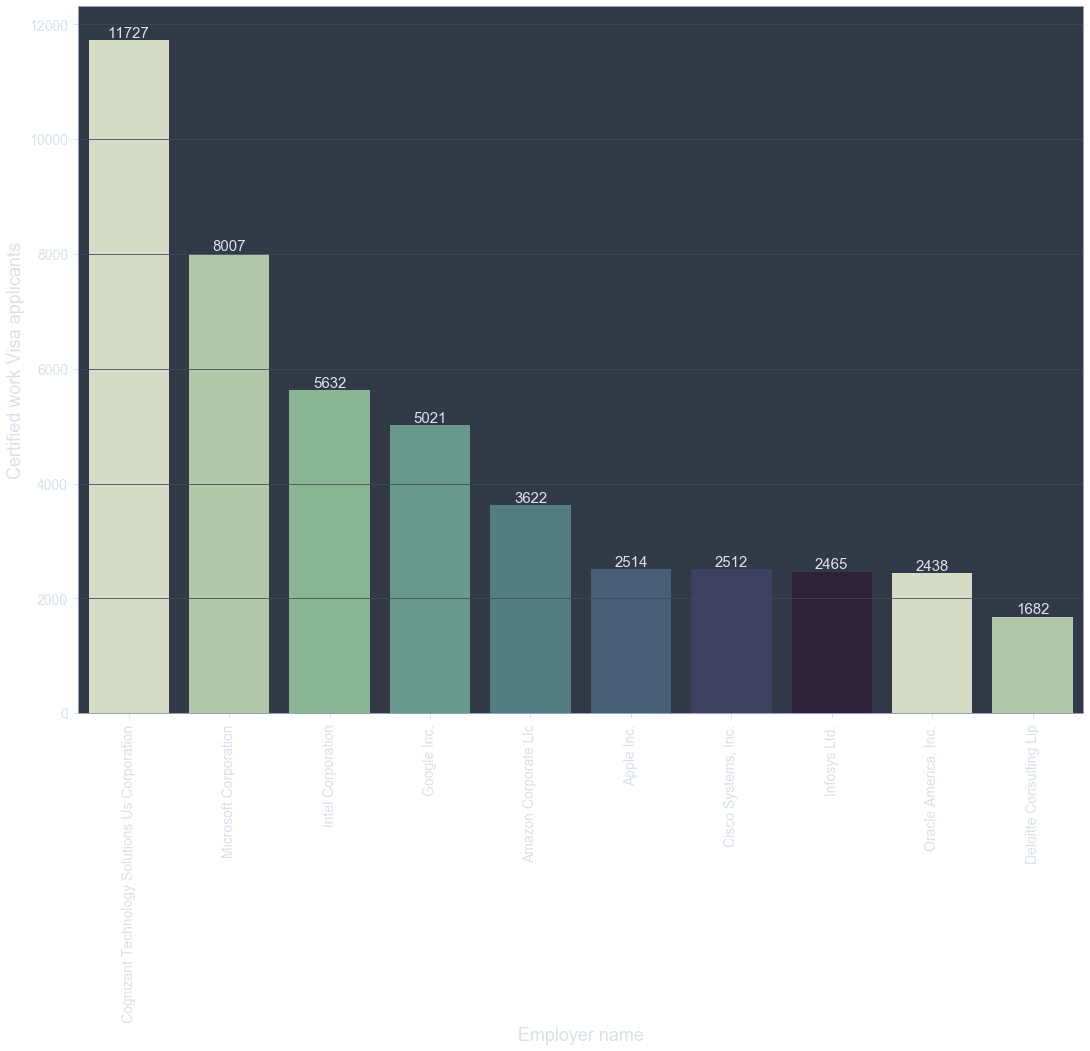

In [492]:
# LETS GET PLOTTING :D!!
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(18, 13)
ax.tick_params(labelsize=14)
sb.set_context(rc={"font.size":15,"axes.titlesize":18,"axes.labelsize":18})
sb.countplot(x='employer_name', data=certified_data, palette = sb.cubehelix_palette(8, start=.5, rot=-.75), order=certified_data.employer_name.value_counts().iloc[:10].index)
plt.xticks(rotation=90)

#Iterating over elements in "employer_name" column and displaying counts above bars 
for i, v in certified_data.employer_name.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.employer_name,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')
    
ax.set(xlabel='Employer name', ylabel='Certified work Visa applicants')
plt.savefig("output/images/top10employers.png", bbox_inches='tight')

In [165]:
#Creating empty dictionary
job_counts = {}

#Iterating over "us_economic_sector" column and appending values to the "job_counts" dictionary
for value in certified_data['naics_us_title'].dropna():
    if value in job_counts:
        job_counts[value] += 1
    else:
        job_counts[value] = 1

In [166]:
job_counts = {k: v for k, v in sorted(job_counts.items(), key=lambda item: item[1], reverse=True)}

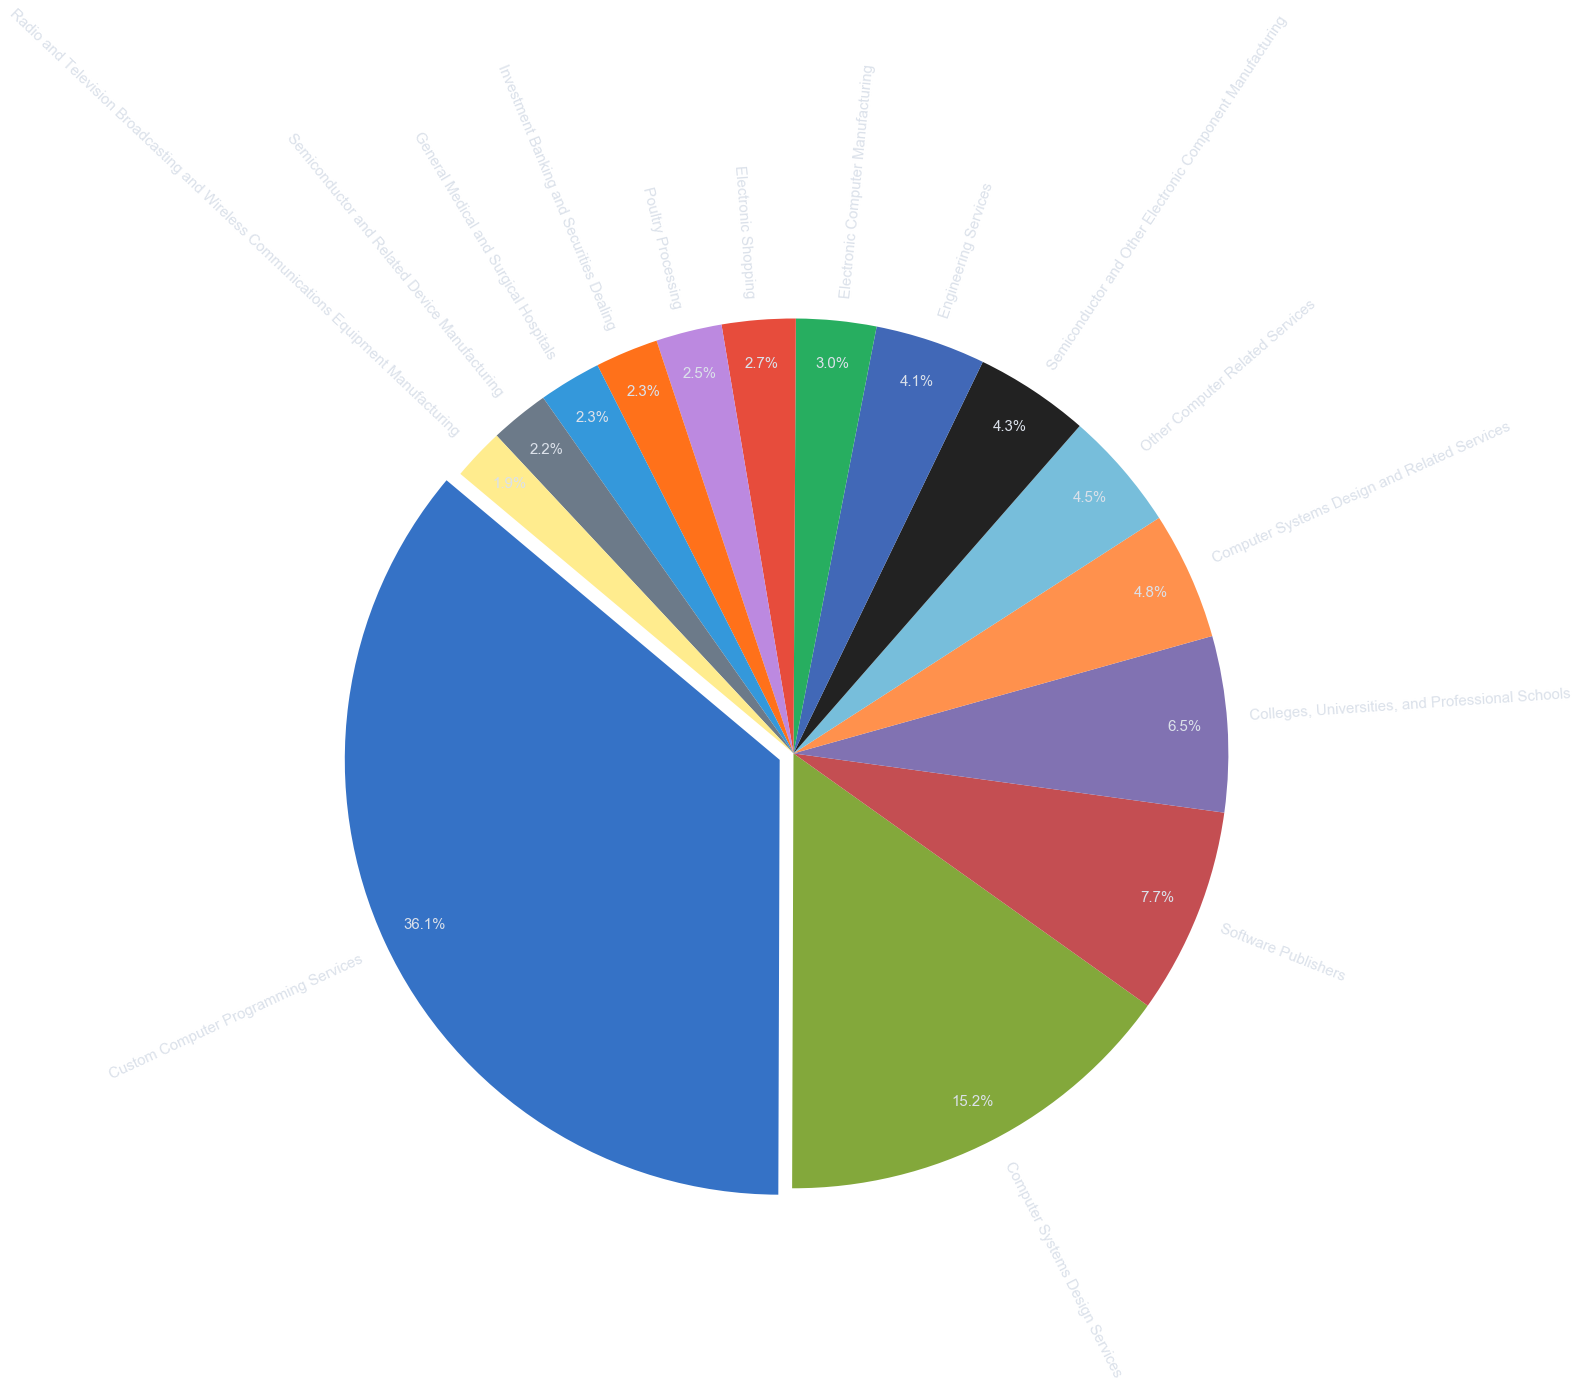

In [208]:
#Creating lists for us economic sectors and their counts
job_labels = []
job_values = []
explode = (0.035, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0)

for key, value in job_counts.items():
    job_labels.append(key)
    job_values.append(value)
    
#Setting plot parameters
plt.figure(figsize=(20,20))    
sb.set_context(rc={"font.size":15,"axes.labelsize":15,"xtick.labelsize" : 15})
plt.pie(job_values[:15], labels=job_labels[:15], explode = explode, autopct='%1.1f%%', pctdistance = 0.9,
          rotatelabels = 90, startangle=140, labeldistance = 1.05) 
# plt.savefig("output_data/images/top10jobfields.png", bbox_inches='tight')
plt.savefig("output_data/images/top15jobfields.png", bbox_inches='tight')
# plt.savefig("output_data/images/top25jobfields.png", bbox_inches='tight')

[Text(0, 0.5, 'Certified work Visa applicants'),
 Text(0.5, 0, 'Employer U.S. State')]

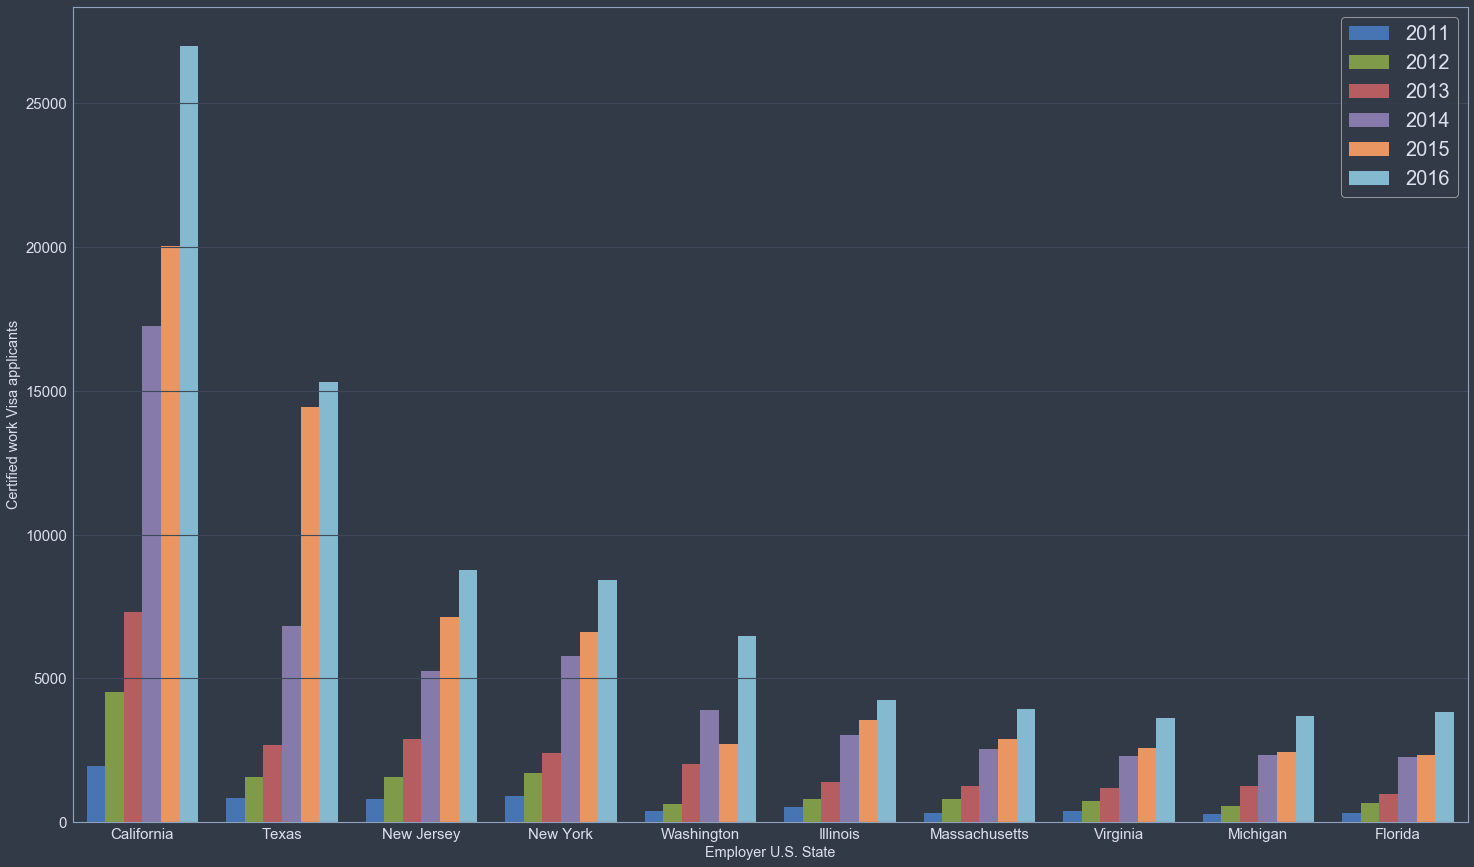

In [32]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=certified_data, order=certified_data.job_info_work_state.value_counts().iloc[:10].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='Certified work Visa applicants')
# plt.savefig("output_data/images/top10states.png", bbox_inches='tight')

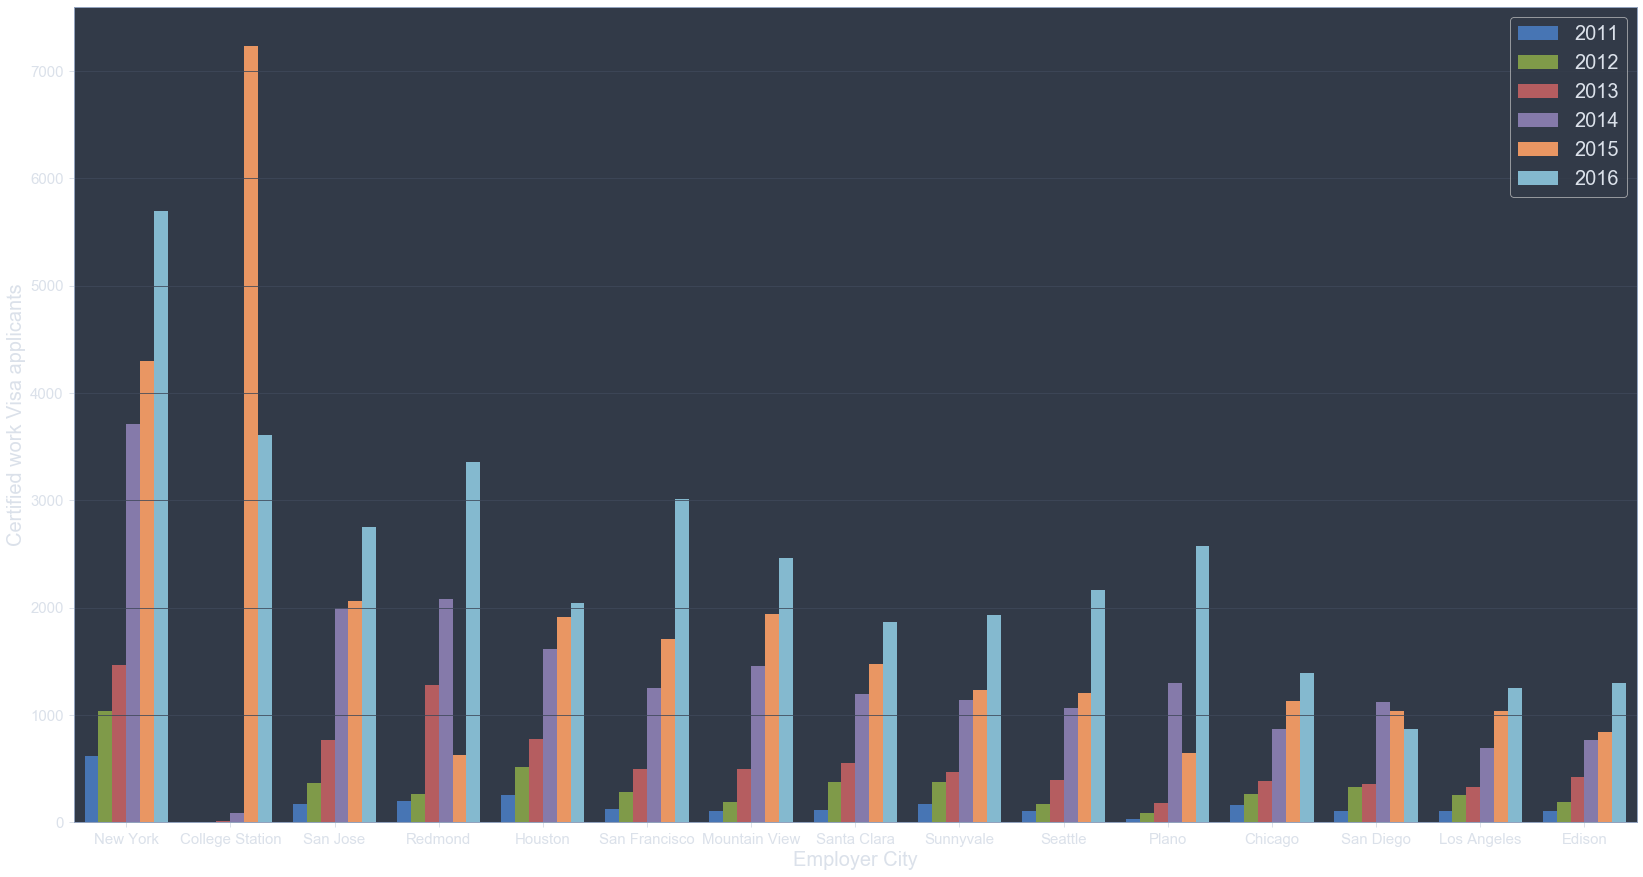

In [357]:
fig, ax = plt.subplots()
fig.set_size_inches(28, 15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=certified_data, order=certified_data.job_info_work_city.value_counts().iloc[:15].index)
plt.legend(loc=1, prop={'size': 20})
ax.tick_params(labelsize=15)
ax.set(xlabel='Employer City', ylabel='Certified work Visa applicants')
plt.savefig("output_data/images/top15cities.png", bbox_inches='tight')

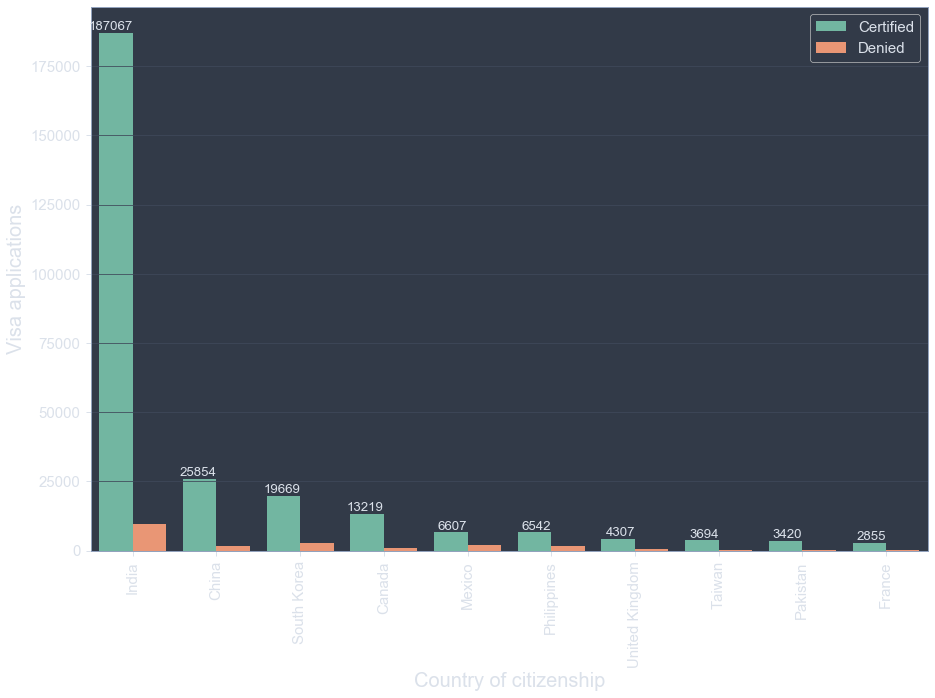

In [487]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sb.set_context(rc={"font.size":13.3,"axes.titlesize":16, "axes.labelsize":14})
sb.countplot(x='country_of_citizenship',hue='case_status',data=useful_data, 
              palette = sb.color_palette("Set2"),
              order=useful_data.country_of_citizenship.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.legend(loc=1, prop={'size': 15})

#Iterating over elements in "country_of_citizenship" column and displaying counts above bars 
for i, v in certified_data.country_of_citizenship.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.country_of_citizenship,v.unique()[1], horizontalalignment='right',verticalalignment='bottom')
    
#Setting label titles    
ax.set(xlabel='Country of citizenship', ylabel='Visa applications')
ax.tick_params(labelsize=15)
plt.savefig("output/images/top10countries.png", bbox_inches='tight')

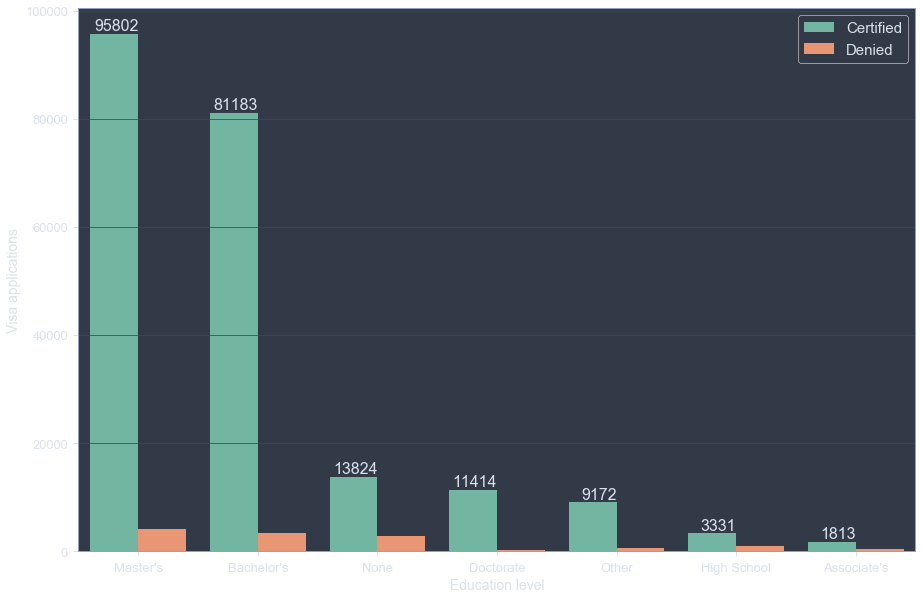

In [489]:
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sb.set_context(rc={"font.size":16,"axes.titlesize":16, "axes.labelsize":14})
sb.countplot(x='foreign_worker_info_education',hue='case_status',data=useful_data, 
              palette = sb.color_palette("Set2"),
              order=useful_data.foreign_worker_info_education.value_counts().iloc[:10].index)
plt.legend(loc=1, prop={'size': 15})

#Iterating over elements in "job_info_job_title" column and displaying counts above bars 
for i, v in certified_data.foreign_worker_info_education.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.foreign_worker_info_education,v.unique()[1], horizontalalignment='right',verticalalignment='bottom')

#Setting label titles    
ax.tick_params(labelsize=13)
ax.set(xlabel='Education level', ylabel='Visa applications')
plt.savefig("output/images/education.png", bbox_inches='tight')

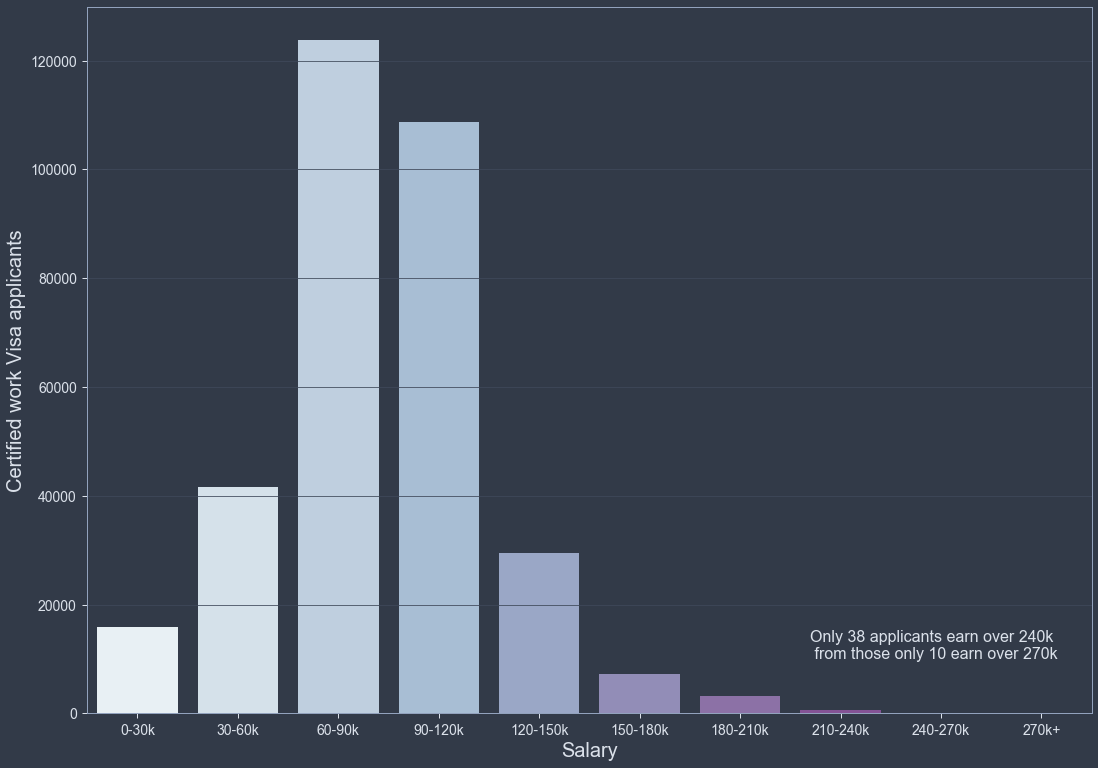

In [38]:
s240=((certified_data['salary']=='240-270k').sum())+((certified_data['salary']=='270k+').sum())
s270=(certified_data['salary']=='270k+').sum()
fig, ax = plt.subplots()
fig.set_size_inches(18, 13)
ax.tick_params(labelsize=14)
sb.set_context(rc={"font.size":16,"axes.titlesize":15,"axes.labelsize":13})
sb.countplot(x='salary', data=certified_data, palette = "BuPu")
ax.text(6.7,10000, f"Only {s240} applicants earn over 240k\n from those only {s270} earn over 270k")
ax.set(xlabel='Salary', ylabel='Certified work Visa applicants')
plt.savefig("output/images/Salary.png", bbox_inches='tight')

In [348]:
certified_data.employer_name.value_counts().iloc[:10].index

Index(['Cognizant Technology Solutions Us Corporation',
       'Microsoft Corporation', 'Intel Corporation', 'Google Inc.',
       'Amazon Corporate Llc', 'Apple Inc.', 'Cisco Systems, Inc.',
       'Infosys Ltd.', 'Oracle America, Inc.', 'Deloitte Consulting Llp'],
      dtype='object')

In [ ]:
#plots for top 5 employers

In [349]:
microsoft_data = certified_data.loc[certified_data['employer_name']=='Microsoft Corporation', :]

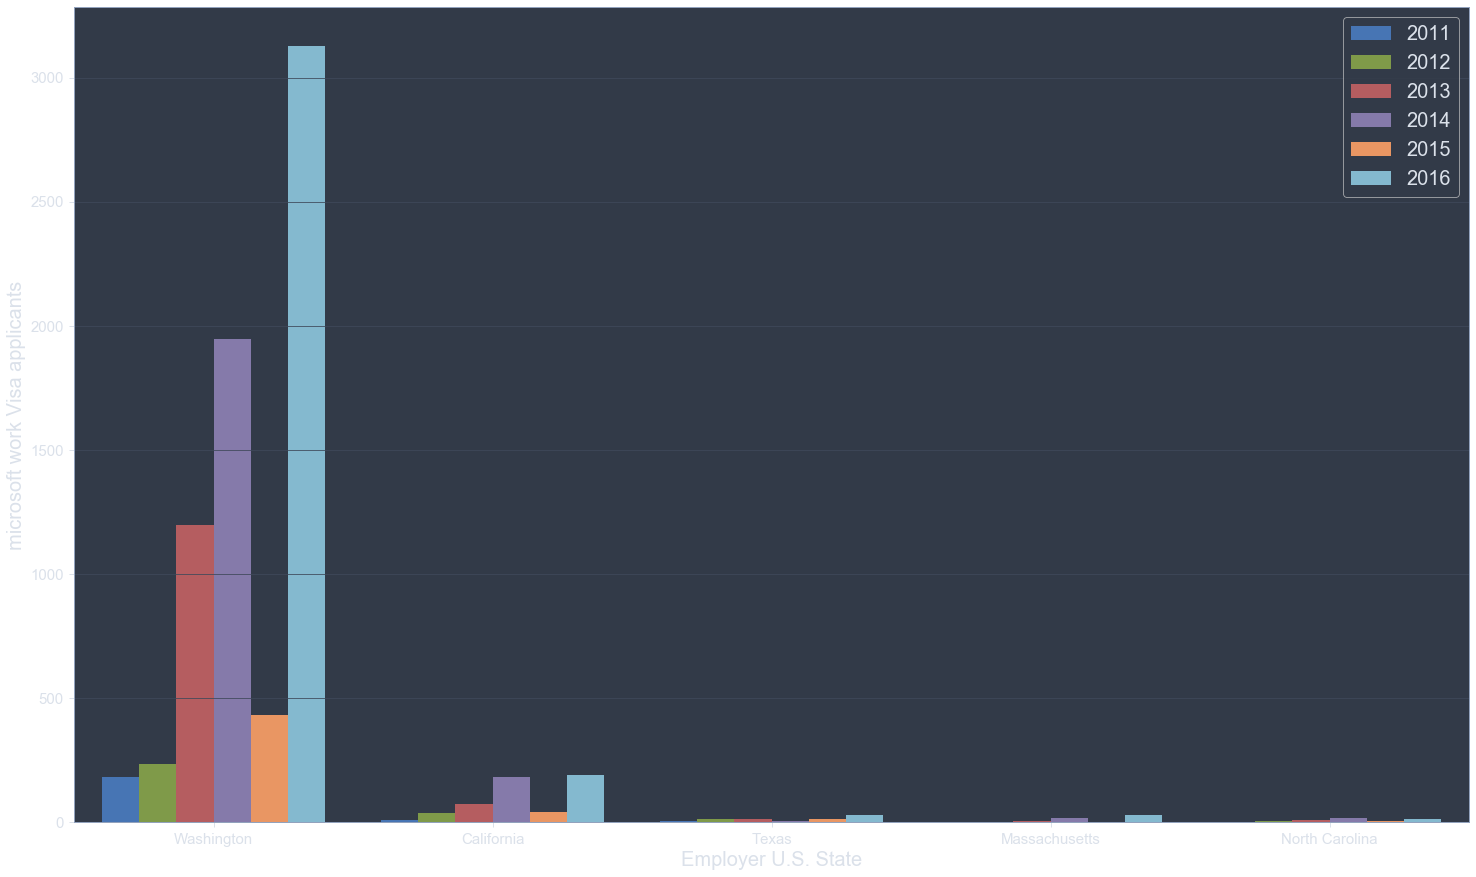

In [412]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=microsoft_data, order=microsoft_data.job_info_work_state.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='microsoft work Visa applicants')
plt.savefig("output_data/images/microsoft10states.png", bbox_inches='tight')

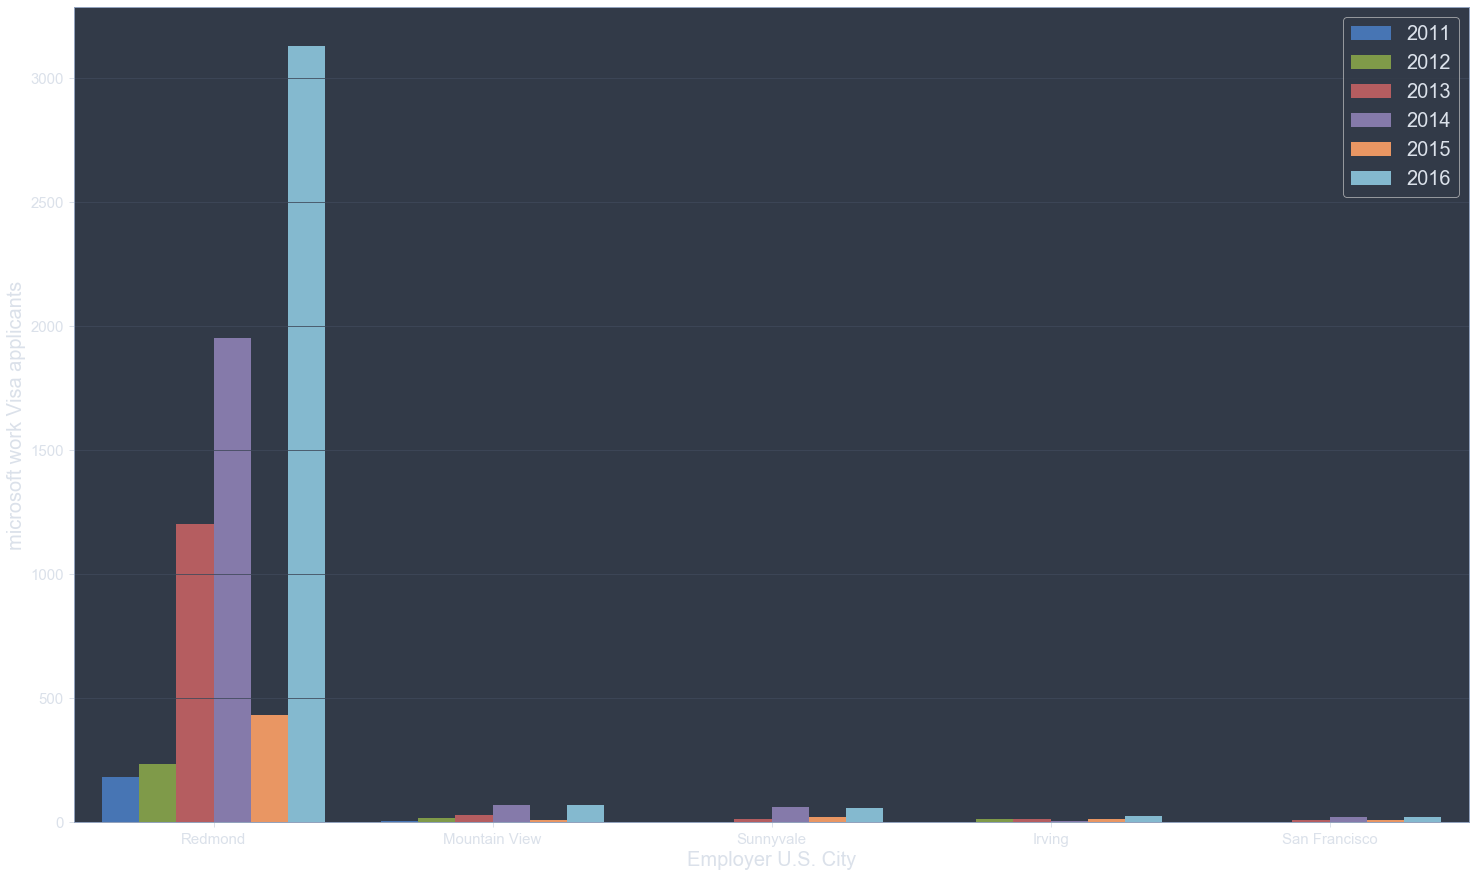

In [413]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=microsoft_data, order=microsoft_data.job_info_work_city.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. City', ylabel='microsoft work Visa applicants')
plt.savefig("output_data/images/microsoftcity.png", bbox_inches='tight')

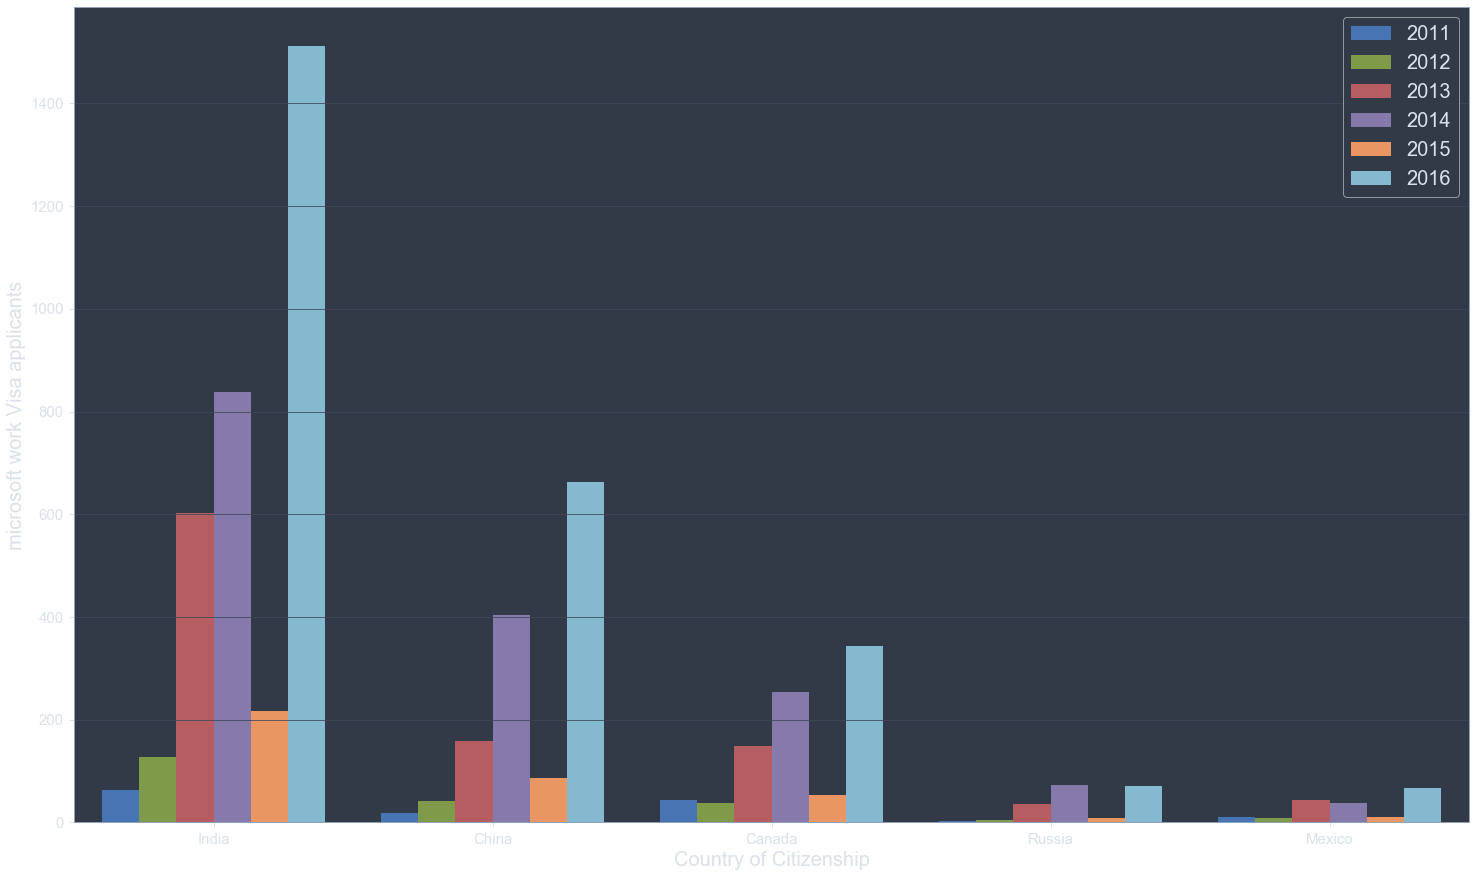

In [423]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='country_of_citizenship', hue='year', data=microsoft_data, order=microsoft_data.country_of_citizenship.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Country of Citizenship', ylabel='microsoft work Visa applicants')
plt.savefig("output_data/images/microsoftcountry.png", bbox_inches='tight')

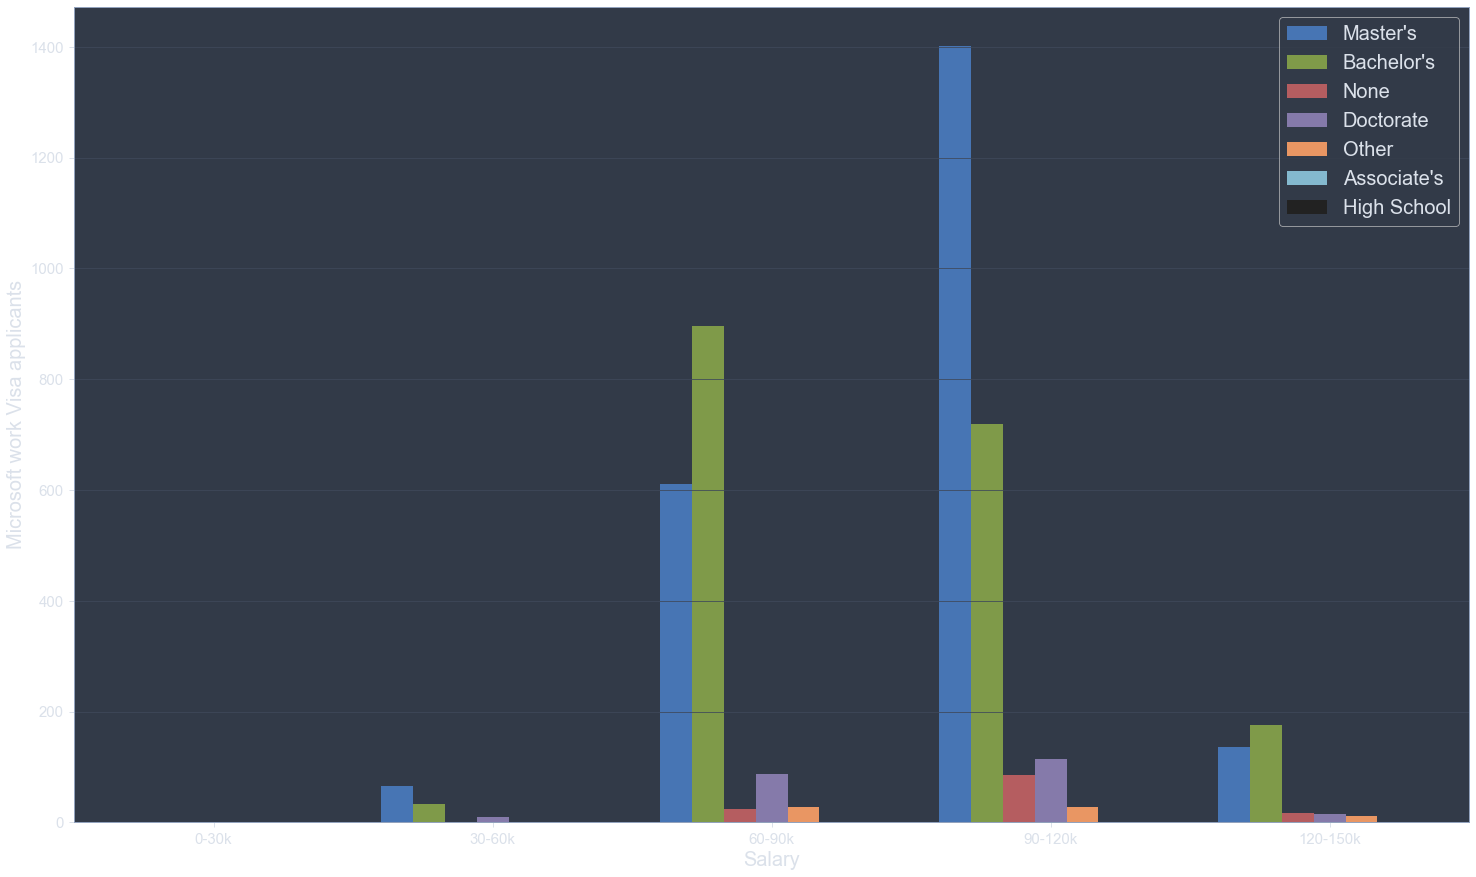

In [415]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=microsoft_data, order=salary.iloc[np.argsort(salary.index)].iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Microsoft work Visa applicants')
plt.savefig("output_data/images/microsoftsalaryedu.png", bbox_inches='tight')

In [403]:
cog_data = certified_data.loc[certified_data['employer_name']=='Cognizant Technology Solutions Us Corporation', :]

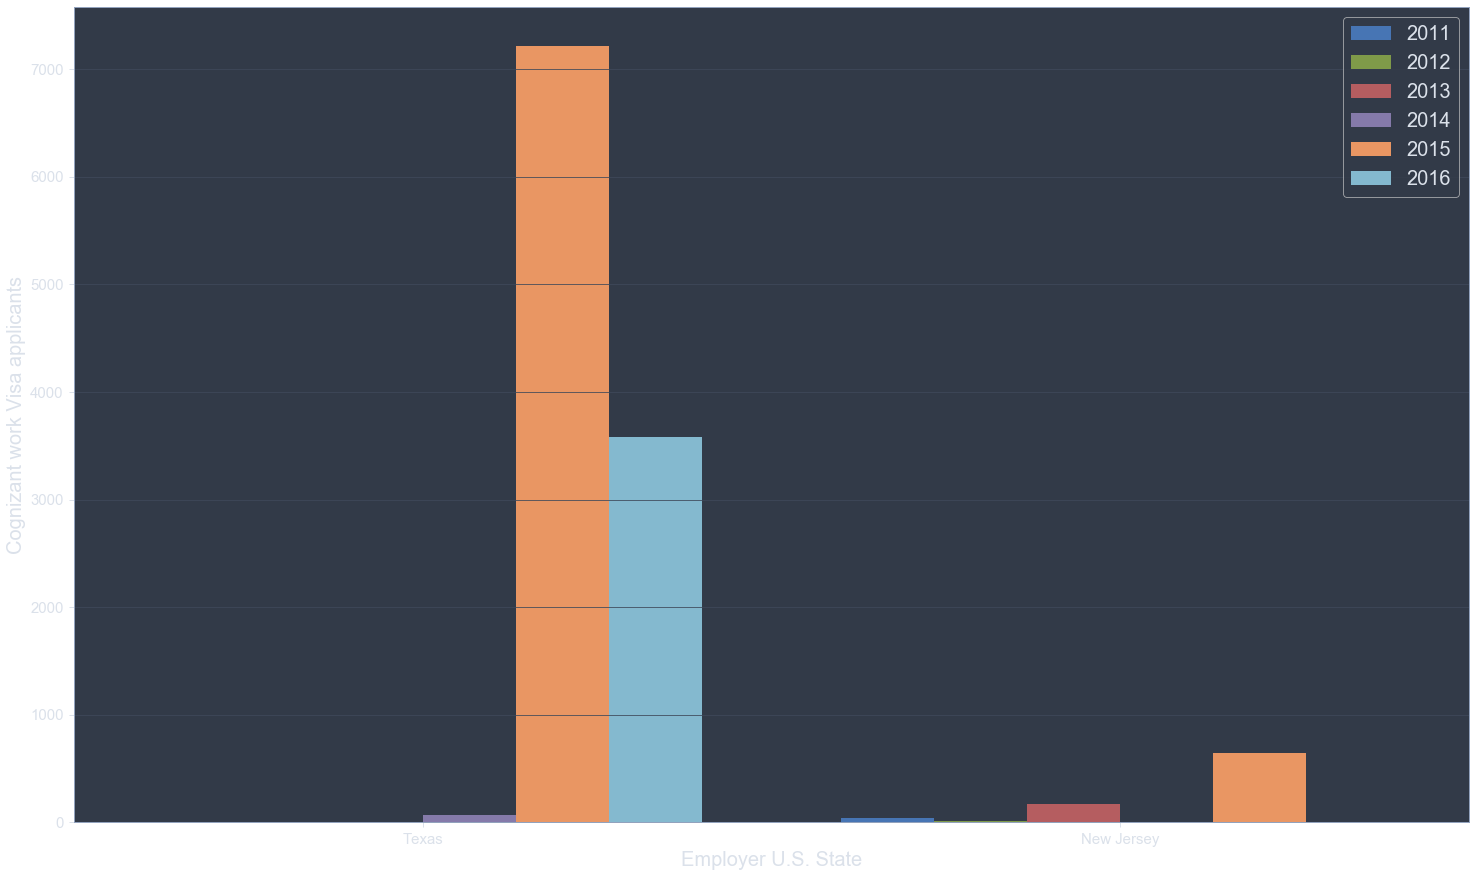

In [408]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=cog_data, order=cog_data.job_info_work_state.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='Cognizant work Visa applicants')
plt.savefig("output_data/images/Cognizant10states.png", bbox_inches='tight')

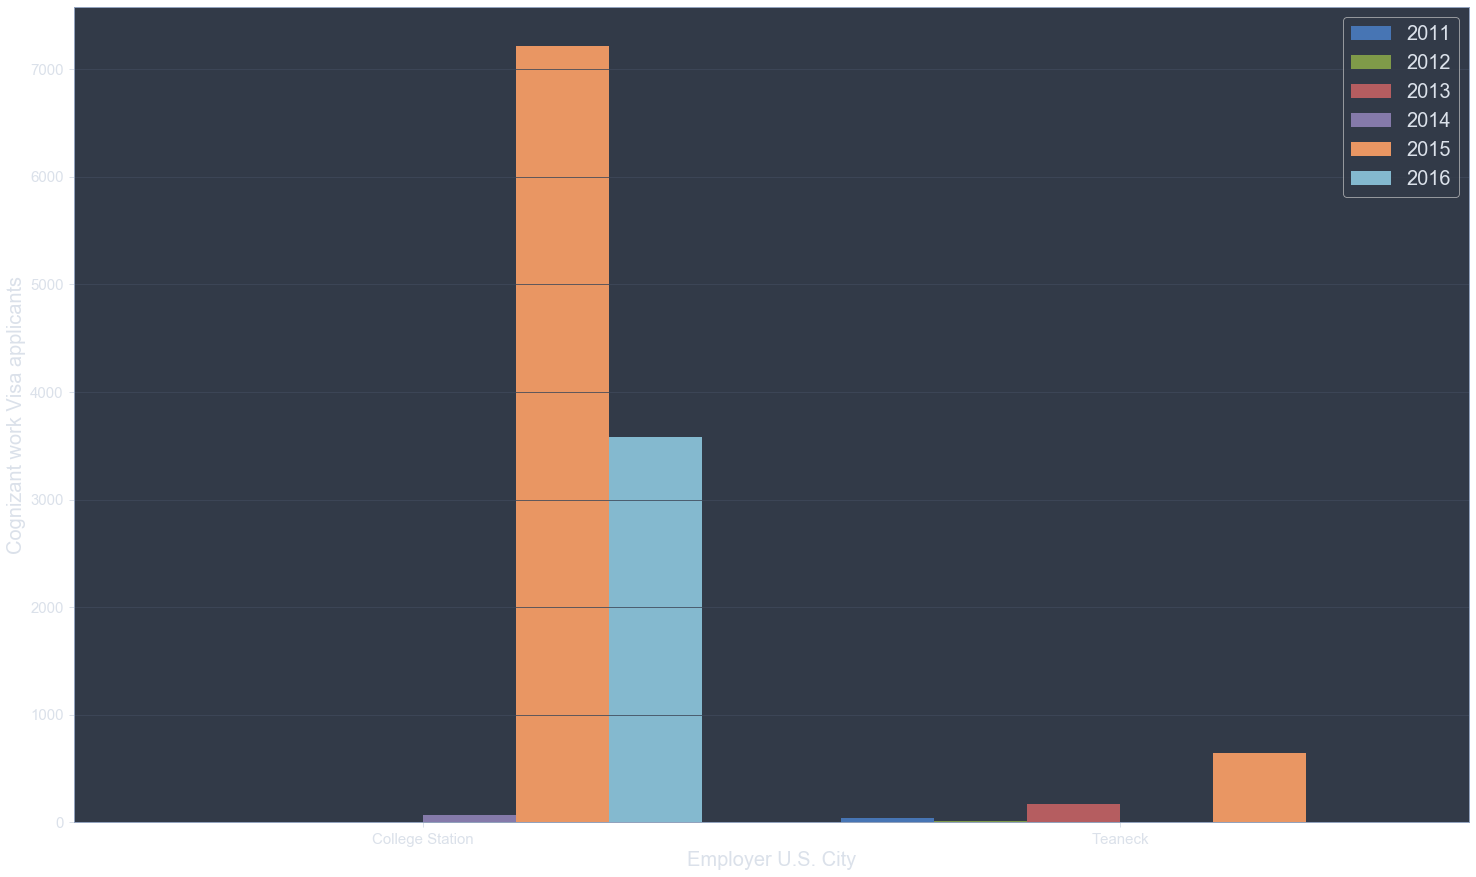

In [409]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=cog_data, order=cog_data.job_info_work_city.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. City', ylabel='Cognizant work Visa applicants')
plt.savefig("output_data/images/Cognizantcity.png", bbox_inches='tight')

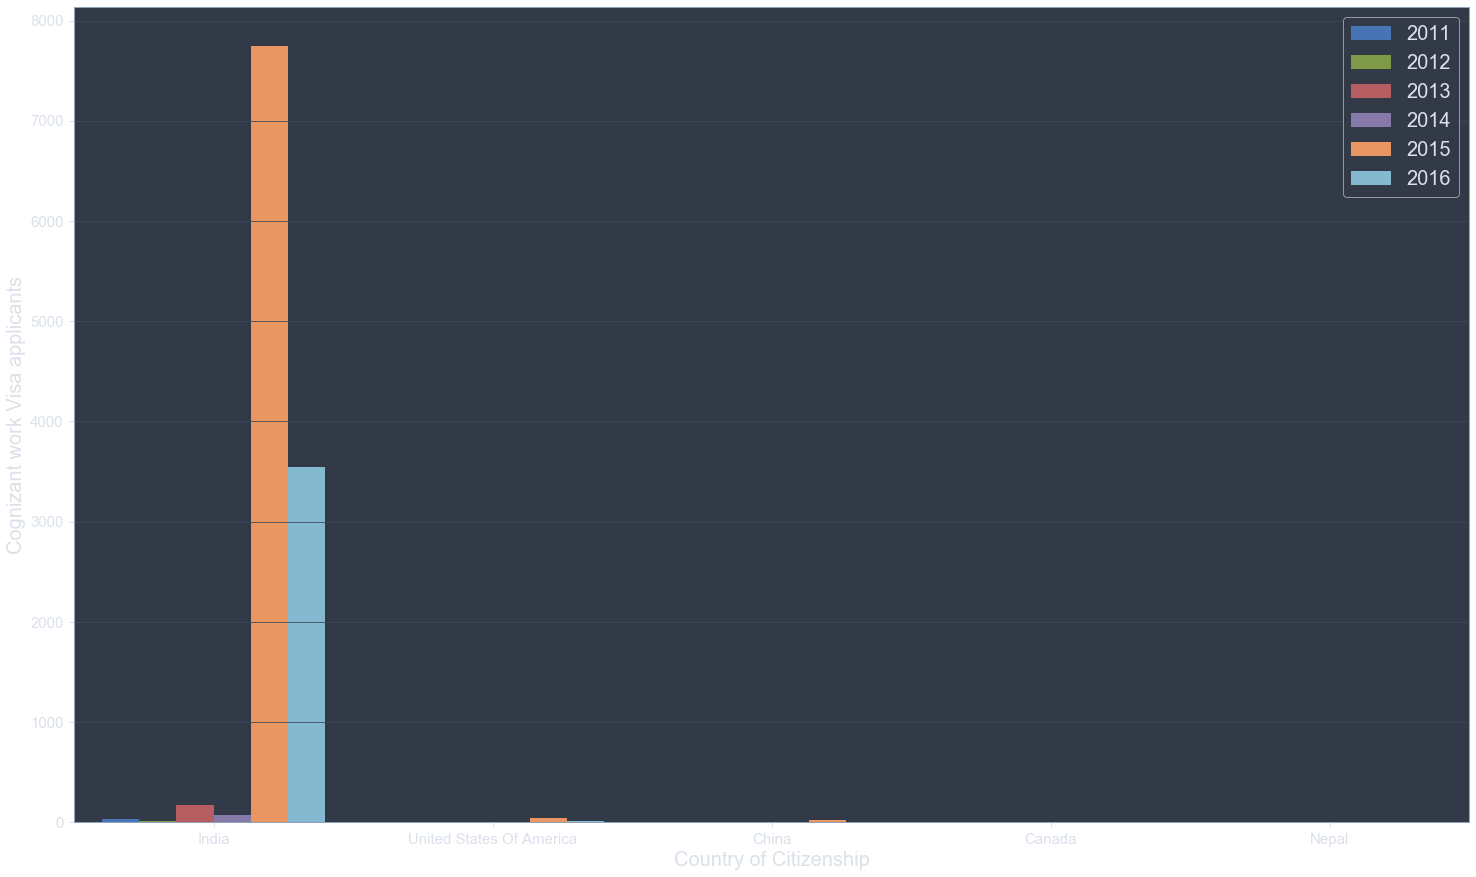

In [422]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='country_of_citizenship', hue='year', data=cog_data, order=cog_data.country_of_citizenship.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Country of Citizenship', ylabel='Cognizant work Visa applicants')
plt.savefig("output_data/images/Cognizantcountry.png", bbox_inches='tight')

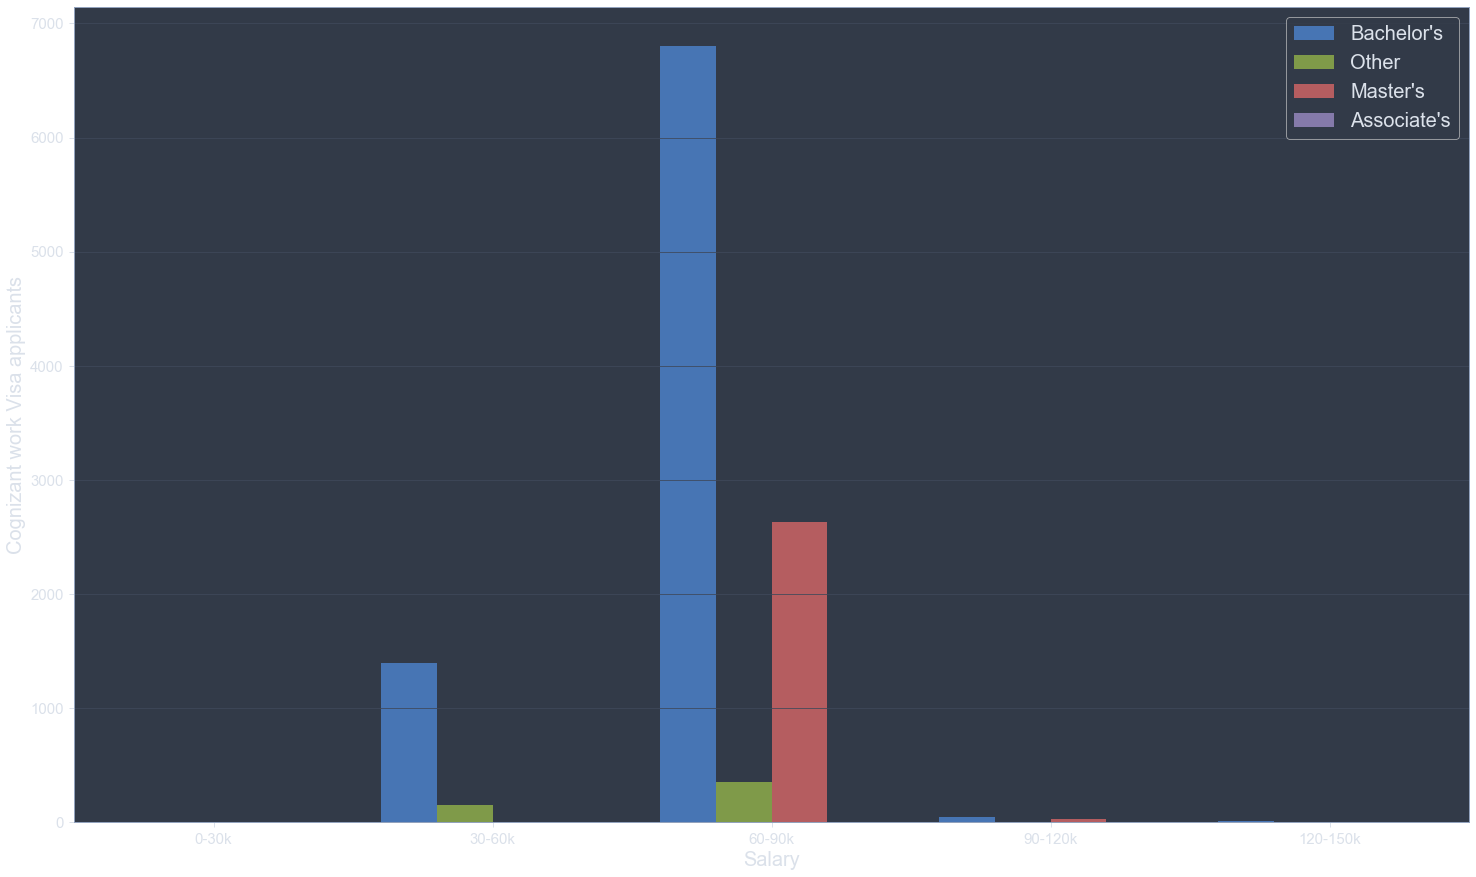

In [411]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=cog_data, order=salary.iloc[np.argsort(salary.index)].iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Cognizant work Visa applicants')
plt.savefig("output_data/images/Cognizantsalaryedu.png", bbox_inches='tight')

In [416]:
intel_data = certified_data.loc[certified_data['employer_name']=='Intel Corporation', :]

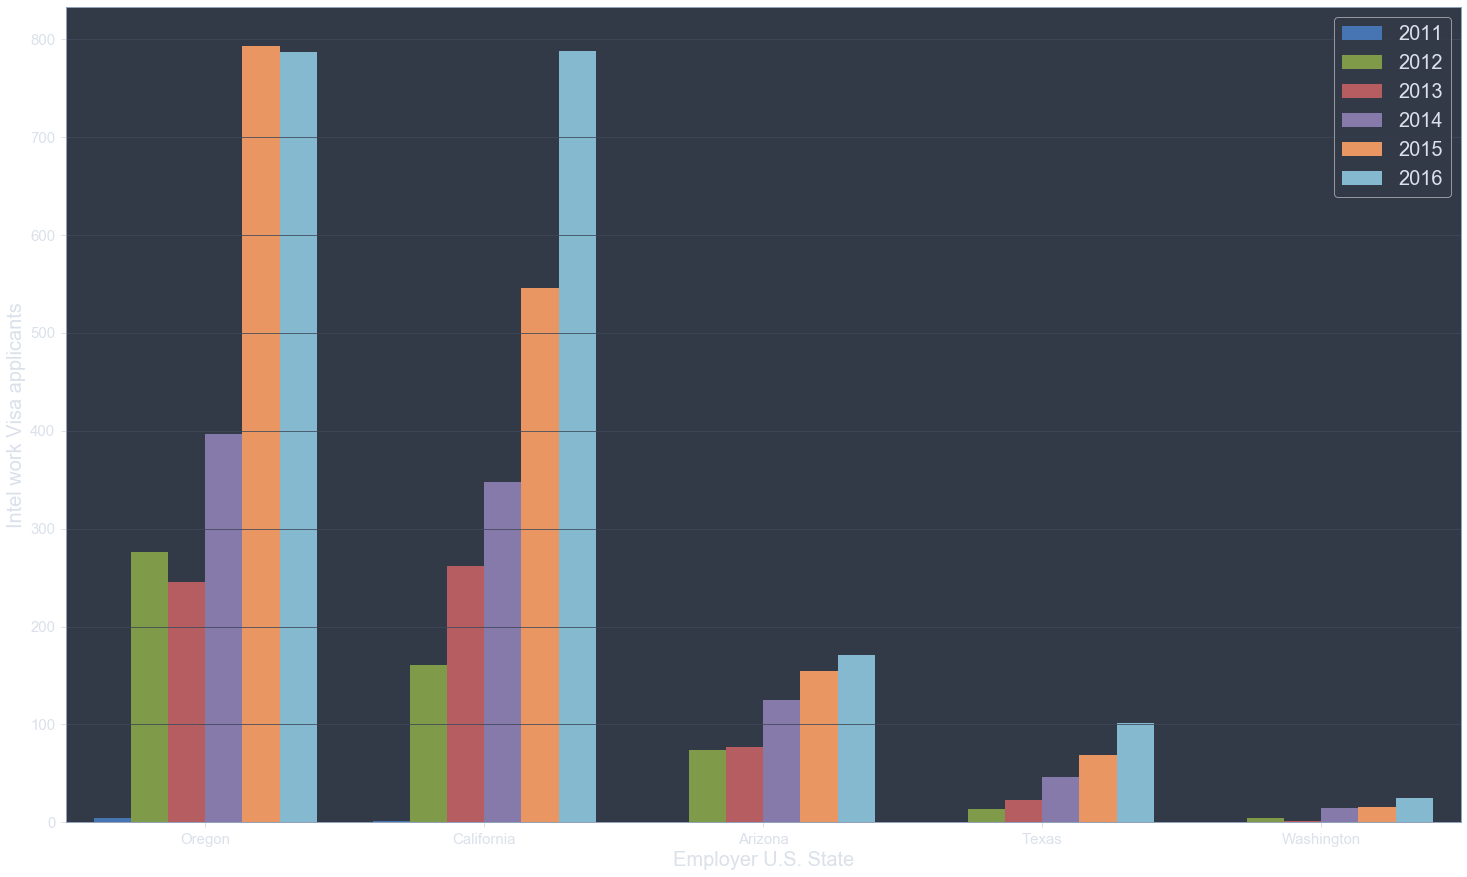

In [417]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=intel_data, order=intel_data.job_info_work_state.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='Intel work Visa applicants')
plt.savefig("output_data/images/Intel10states.png", bbox_inches='tight')

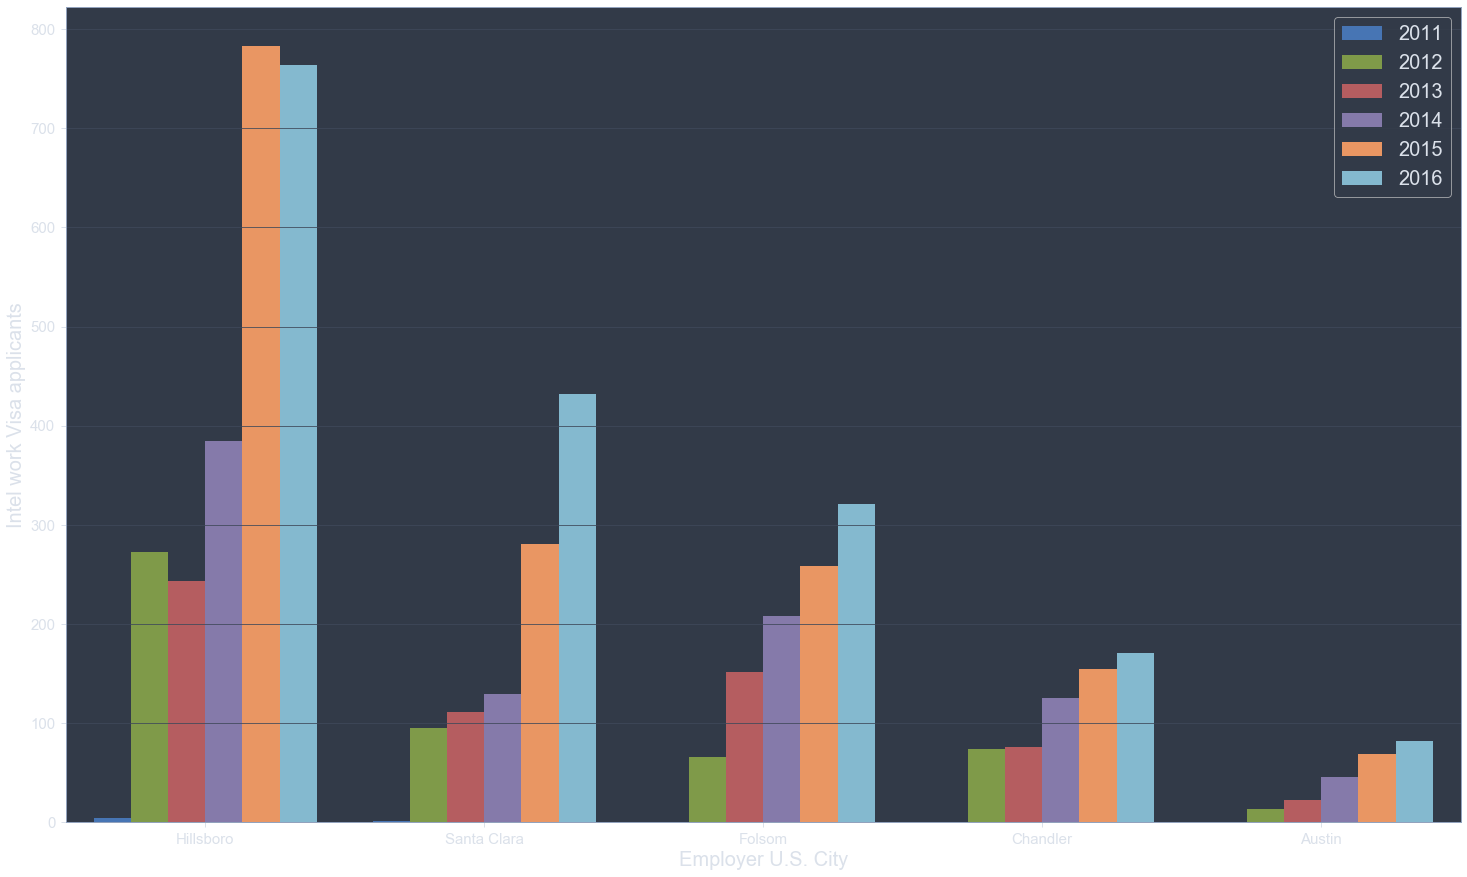

In [418]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=intel_data, order=intel_data.job_info_work_city.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. City', ylabel='Intel work Visa applicants')
plt.savefig("output_data/images/Intelcity.png", bbox_inches='tight')

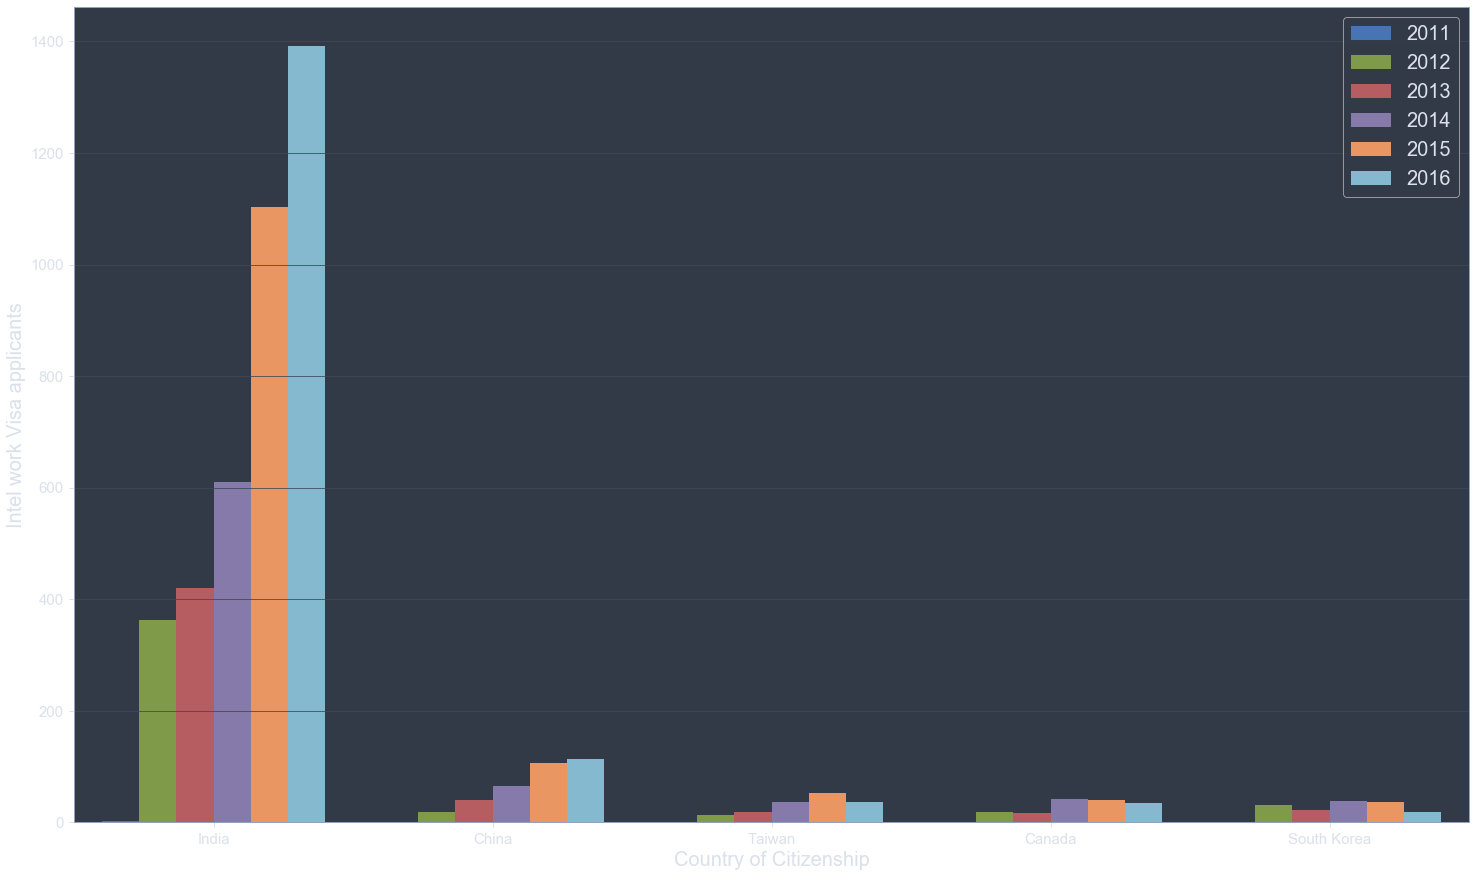

In [421]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='country_of_citizenship', hue='year', data=intel_data, order=intel_data.country_of_citizenship.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Country of Citizenship', ylabel='Intel work Visa applicants')
plt.savefig("output_data/images/Intelcountry.png", bbox_inches='tight')

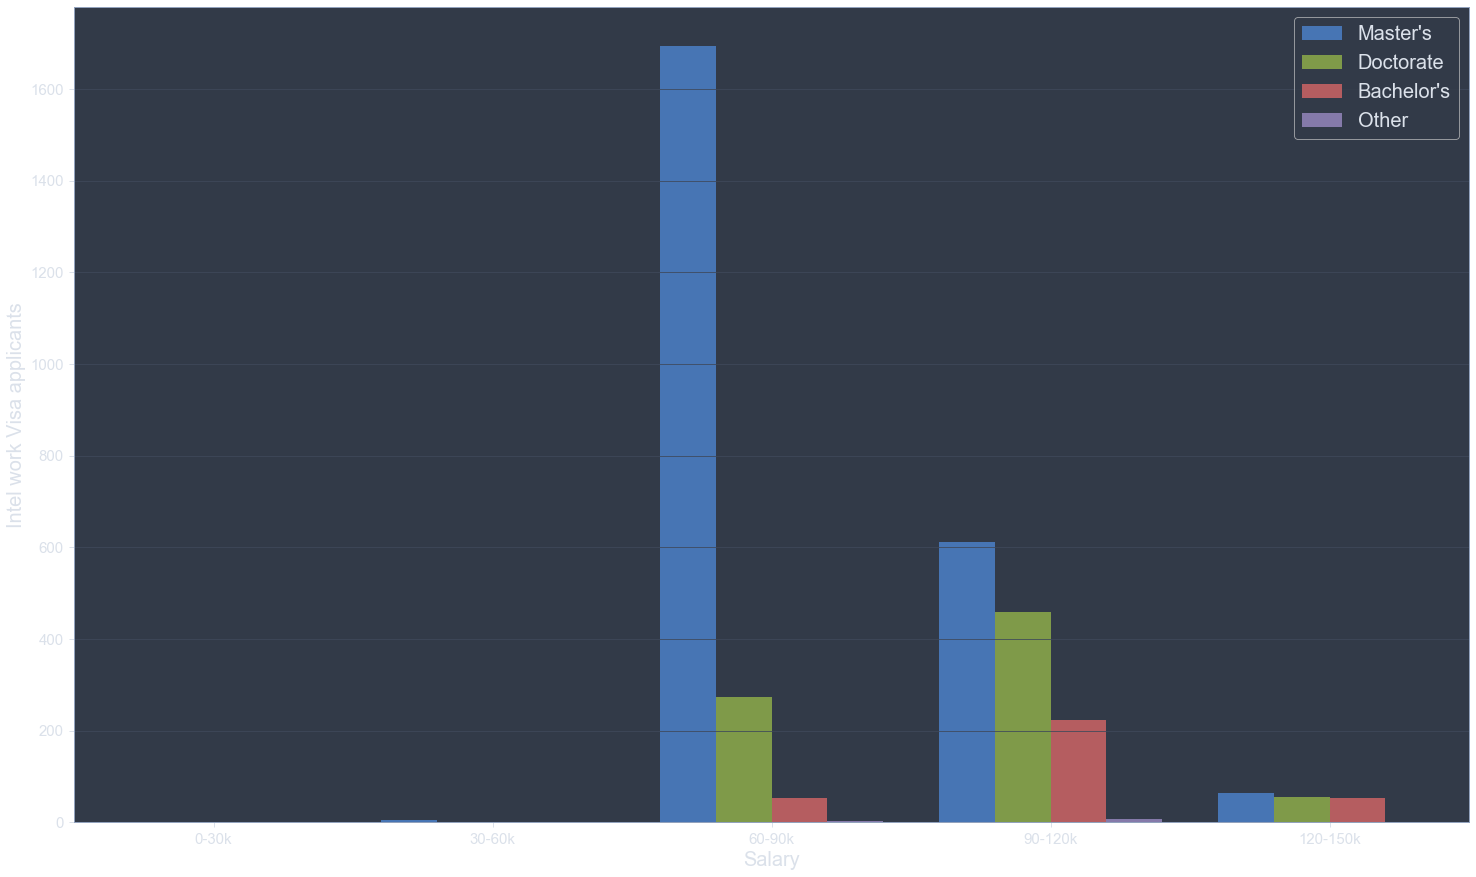

In [420]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=intel_data, order=salary.iloc[np.argsort(salary.index)].iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Intel work Visa applicants')
plt.savefig("output_data/images/Intelsalaryedu.png", bbox_inches='tight')

In [424]:
google_data = certified_data.loc[certified_data['employer_name']=='Google Inc.', :]

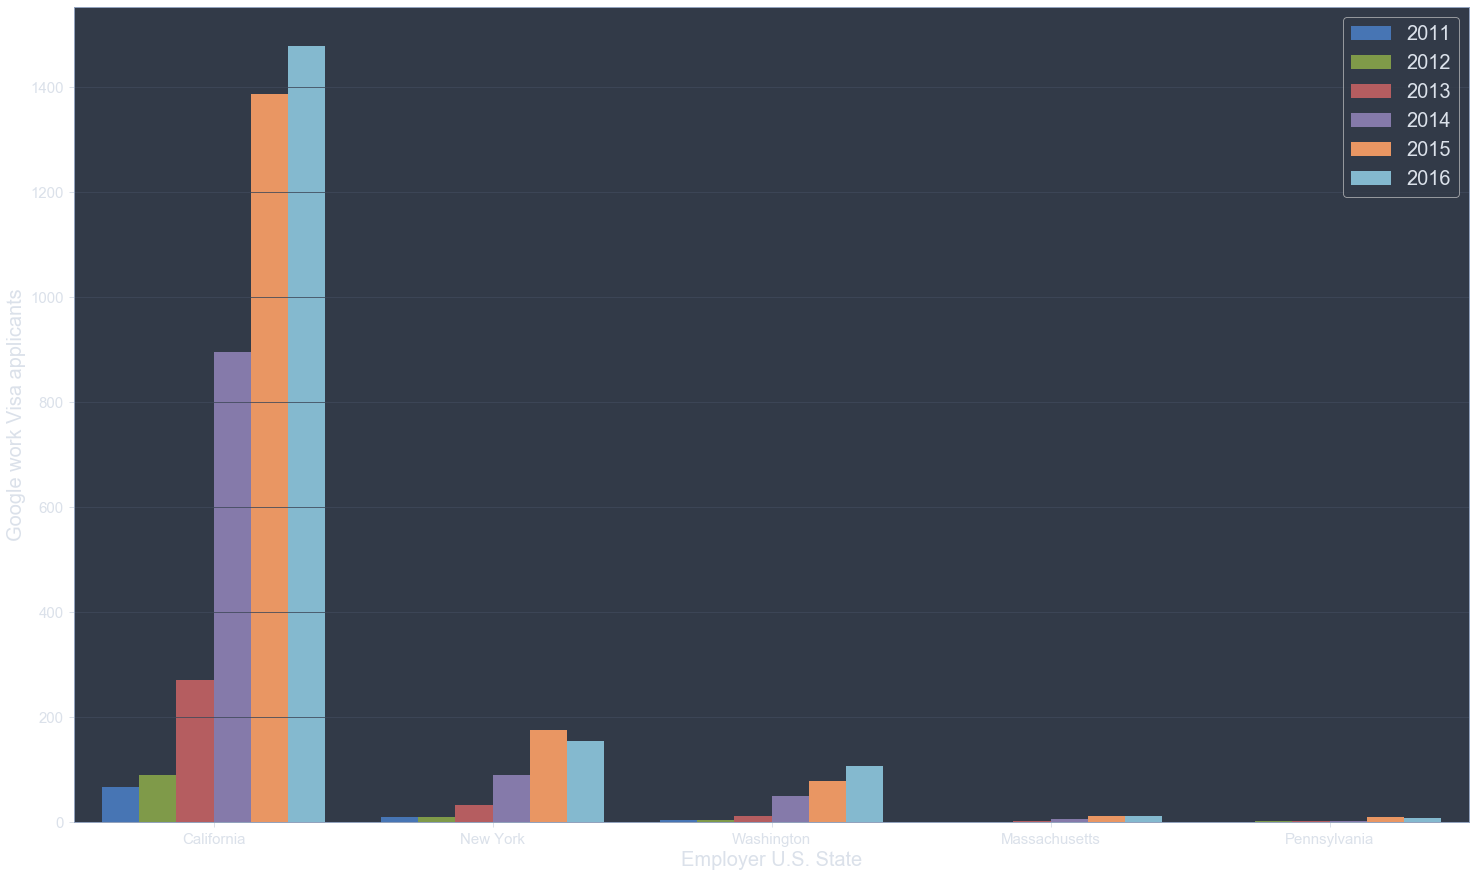

In [425]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=google_data, order=google_data.job_info_work_state.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='Google work Visa applicants')
plt.savefig("output_data/images/Google10states.png", bbox_inches='tight')

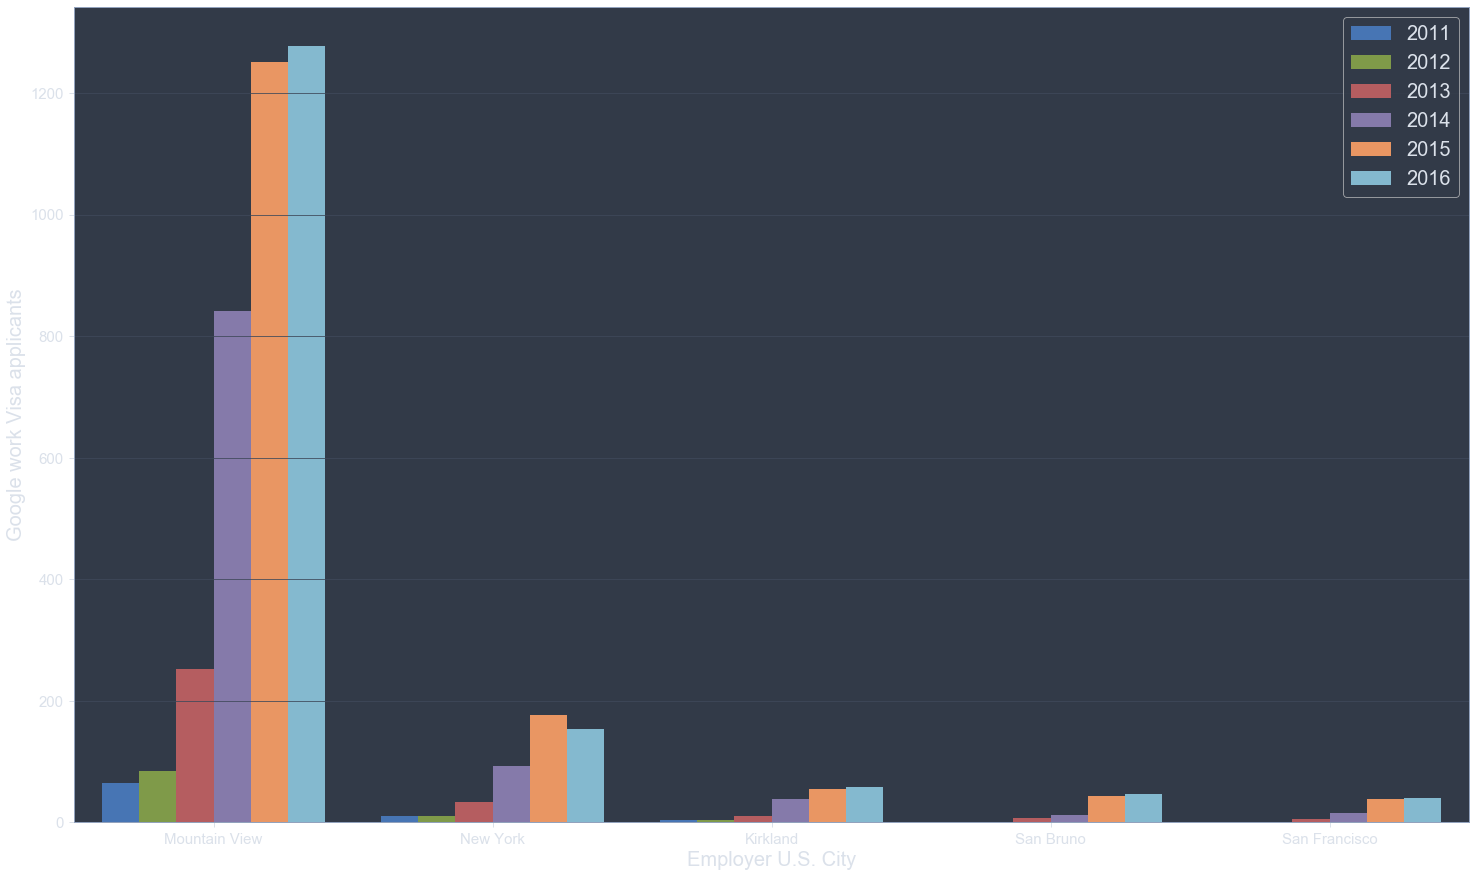

In [426]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=google_data, order=google_data.job_info_work_city.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. City', ylabel='Google work Visa applicants')
plt.savefig("output_data/images/Googlecity.png", bbox_inches='tight')

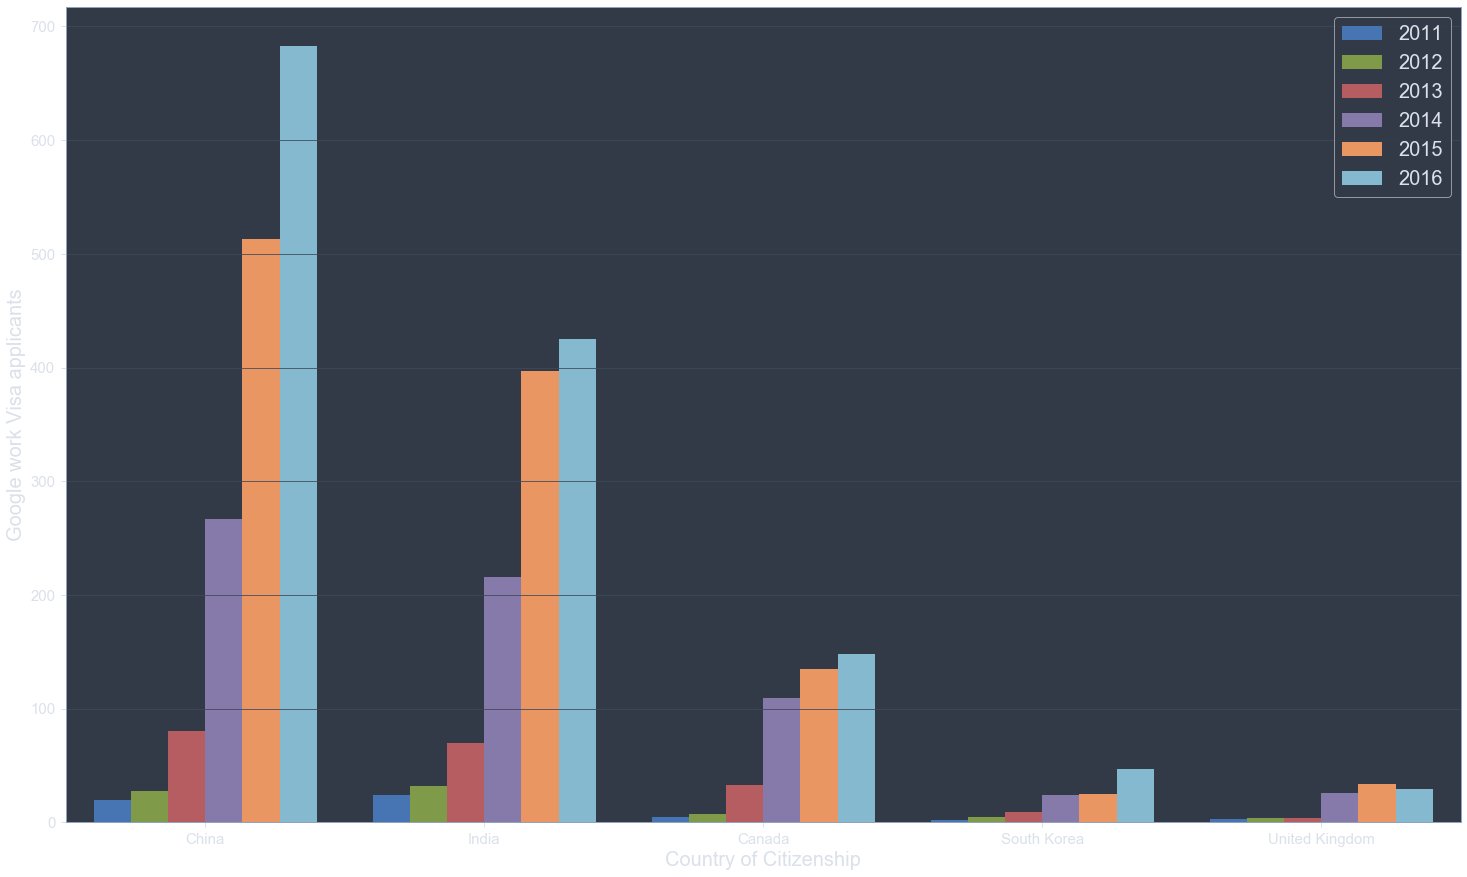

In [427]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='country_of_citizenship', hue='year', data=google_data, order=google_data.country_of_citizenship.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Country of Citizenship', ylabel='Google work Visa applicants')
plt.savefig("output_data/images/Googlecountry.png", bbox_inches='tight')

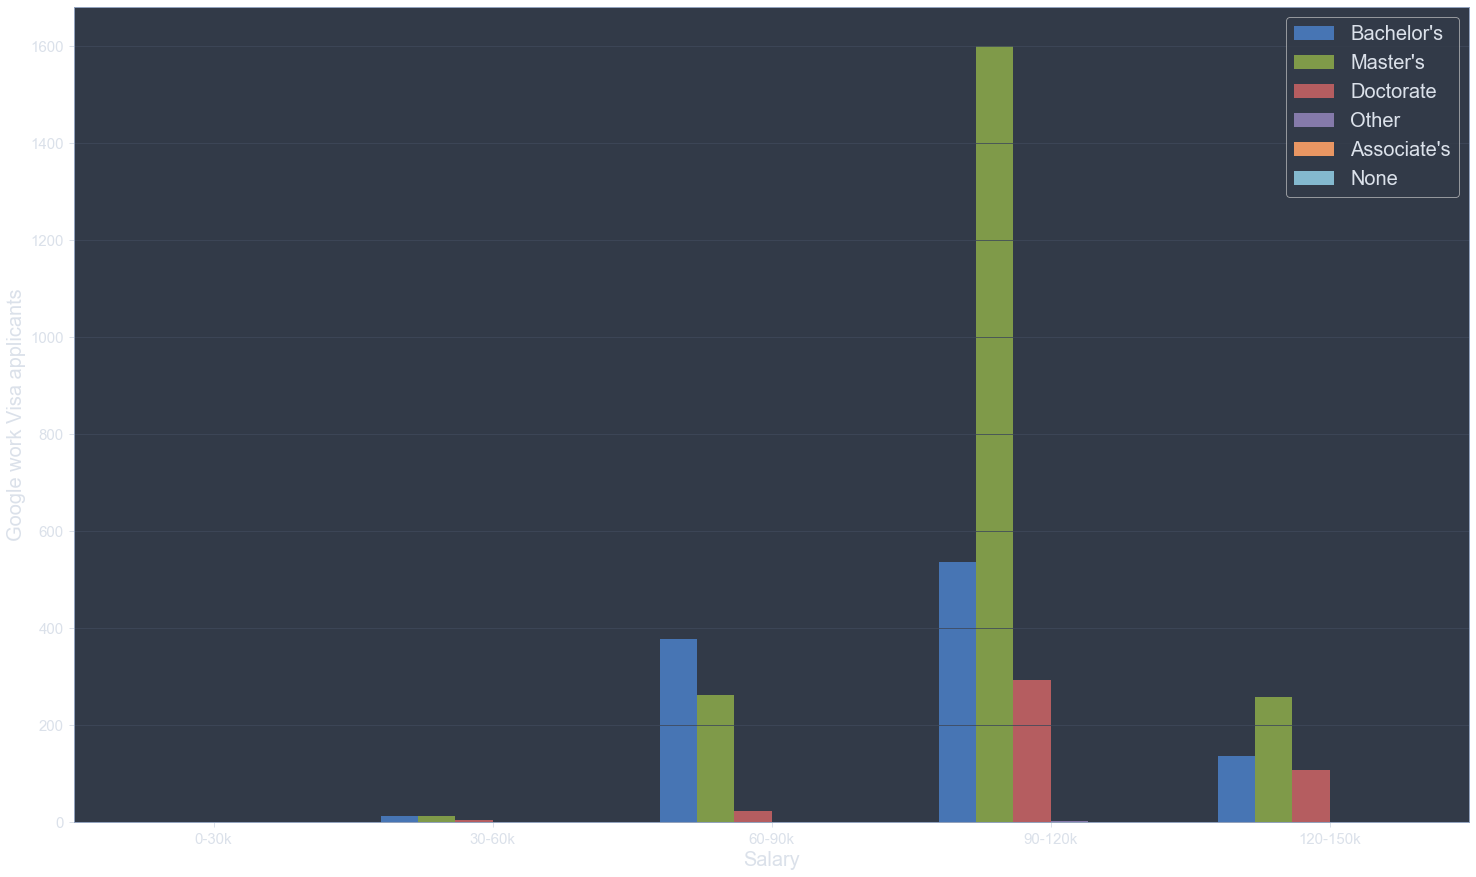

In [428]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=google_data, order=salary.iloc[np.argsort(salary.index)].iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Google work Visa applicants')
plt.savefig("output_data/images/Googlesalaryedu.png", bbox_inches='tight')

In [429]:
amazon_data = certified_data.loc[certified_data['employer_name']=='Amazon Corporate Llc', :]

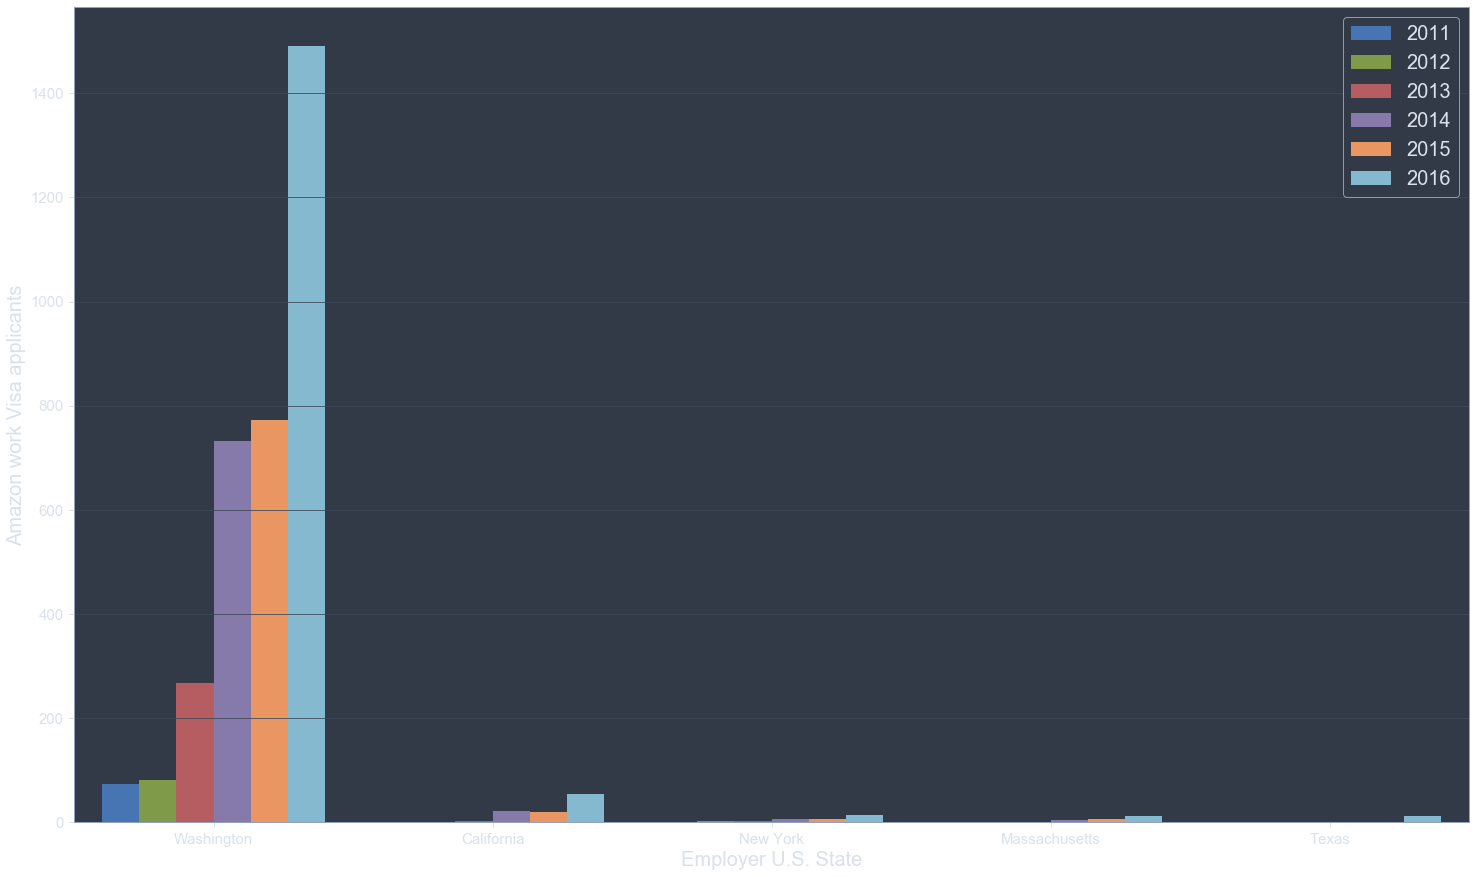

In [430]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_state', hue='year', data=amazon_data, order=amazon_data.job_info_work_state.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. State', ylabel='Amazon work Visa applicants')
plt.savefig("output_data/images/Amazon10states.png", bbox_inches='tight')

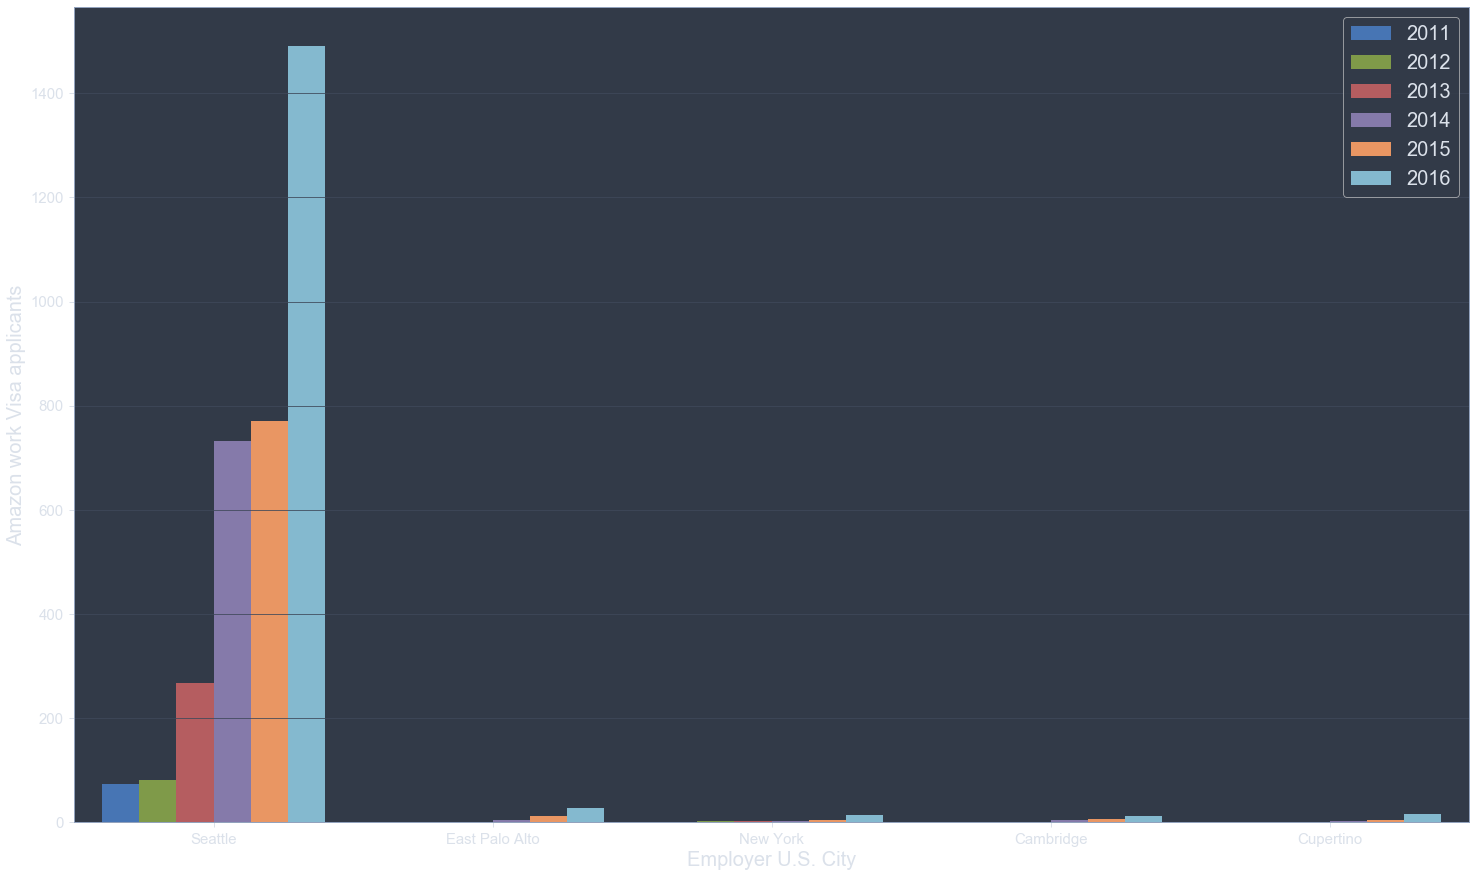

In [431]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='job_info_work_city', hue='year', data=amazon_data, order=amazon_data.job_info_work_city.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Employer U.S. City', ylabel='Amazon work Visa applicants')
plt.savefig("output_data/images/Amazoncity.png", bbox_inches='tight')

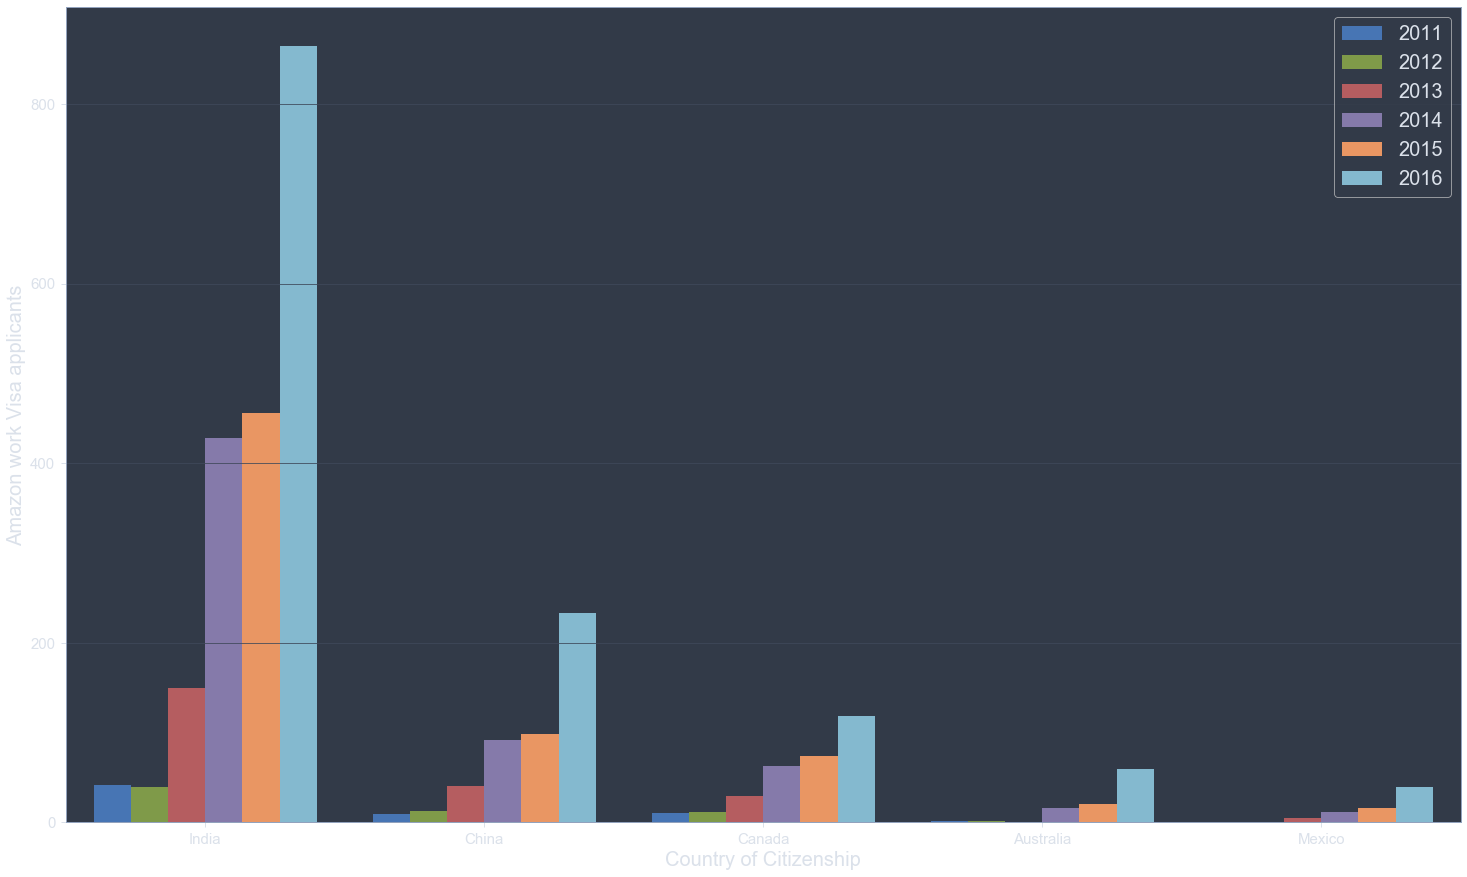

In [432]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='country_of_citizenship', hue='year', data=amazon_data, order=amazon_data.country_of_citizenship.value_counts().iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Country of Citizenship', ylabel='Amazon work Visa applicants')
plt.savefig("output_data/images/Amazoncountry.png", bbox_inches='tight')

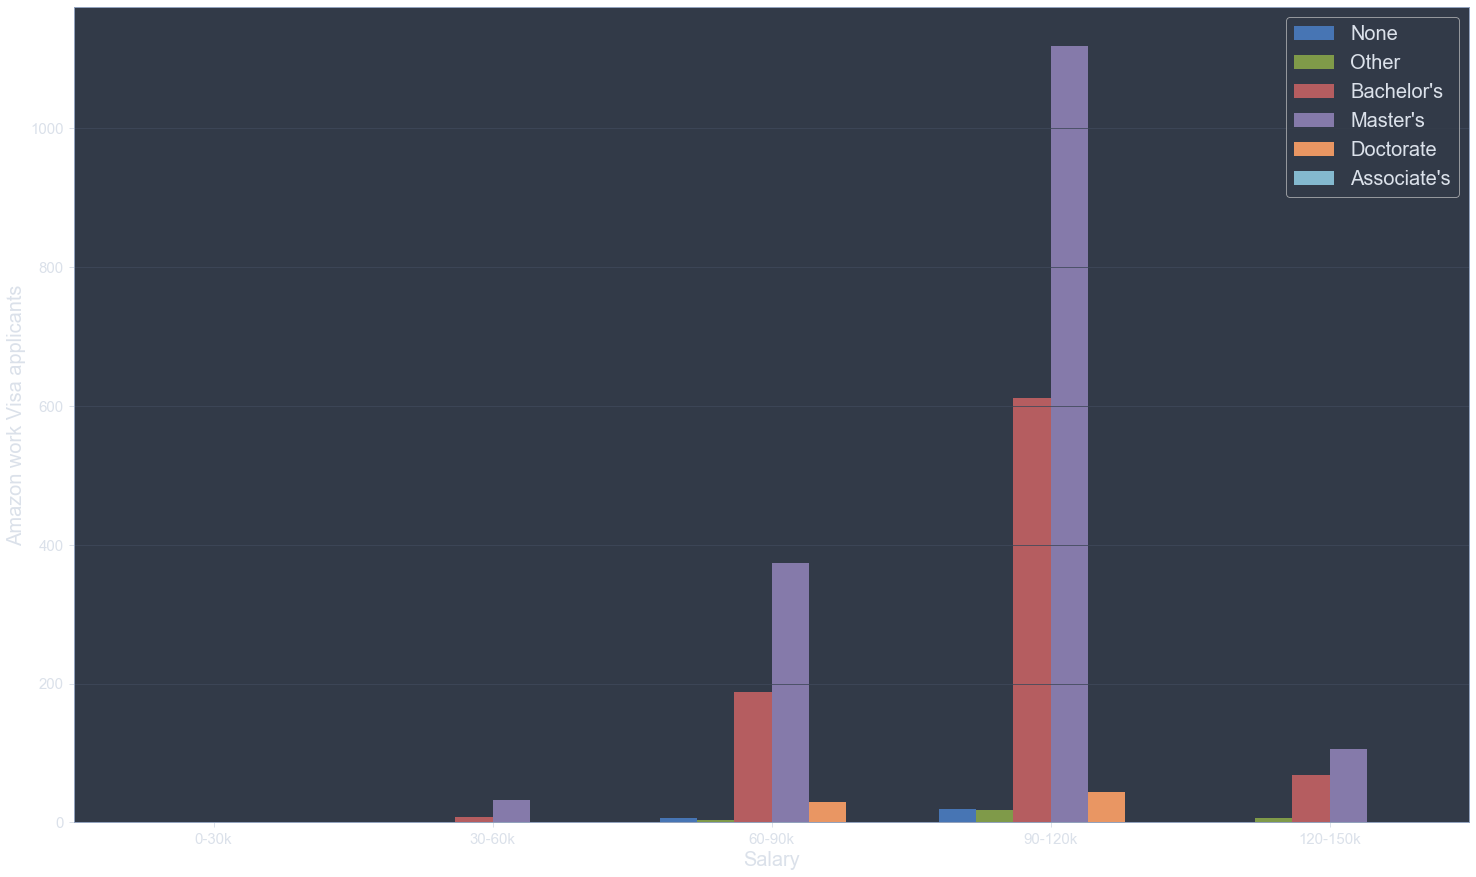

In [433]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=amazon_data, order=salary.iloc[np.argsort(salary.index)].iloc[:5].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Amazon work Visa applicants')
plt.savefig("output_data/images/Amazonsalaryedu.png", bbox_inches='tight')

[Text(0, 0.5, 'Certified work Visa applicants'), Text(0.5, 0, 'Salary')]

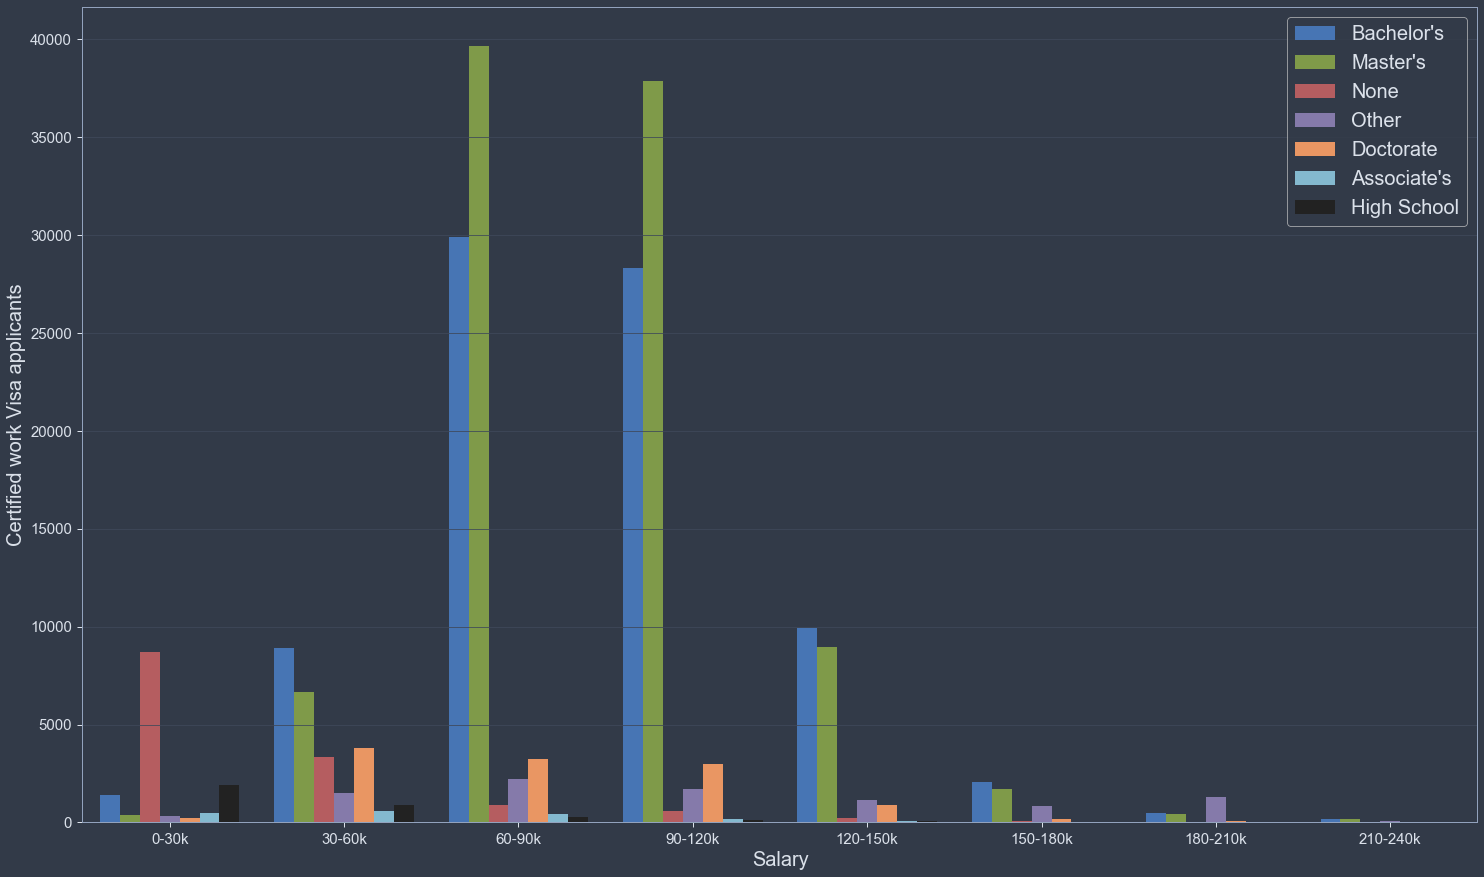

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=certified_data, order=certified_salary.iloc[np.argsort(salary.index)].iloc[:8].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Certified work Visa applicants')
# plt.savefig("output/images/edusalary.png", bbox_inches='tight')

In [39]:
india_data = certified_data.loc[certified_data['country_of_citizenship']=='India', :]

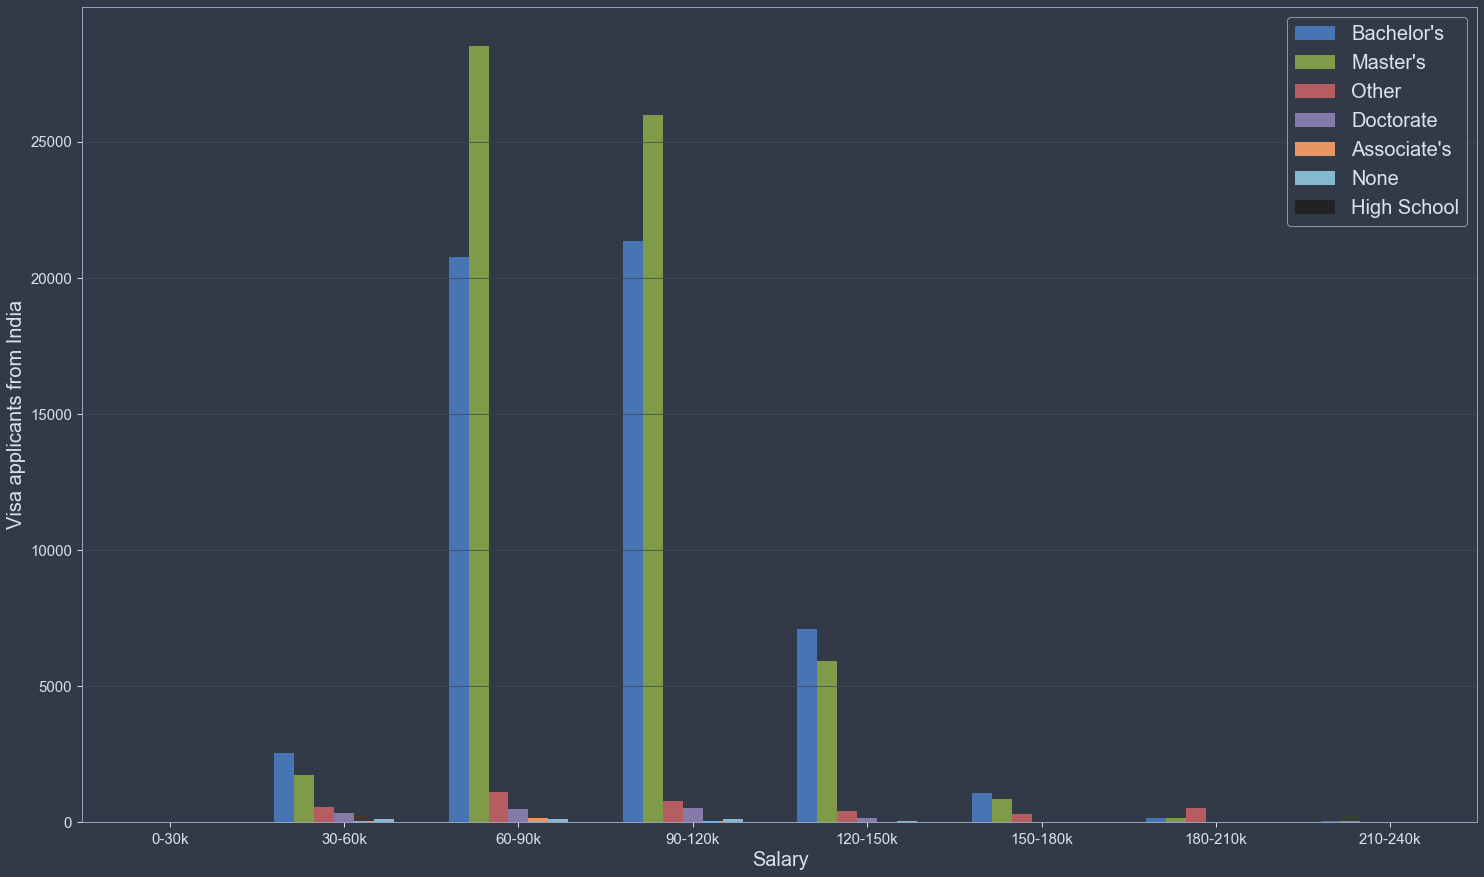

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.tick_params(labelsize=15)
sb.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sb.countplot(x='salary', hue='foreign_worker_info_education', data=india_data, order=salary.iloc[np.argsort(salary.index)].iloc[:8].index)
plt.legend(loc=1, prop={'size': 20})
ax.set(xlabel='Salary', ylabel='Visa applicants from India')
plt.savefig("output/images/Indiasalary.png", bbox_inches='tight')

In [496]:
#Creating empty dictionary
india_job_counts = {}

#Iterating over "us_economic_sector" column and appending values to the "india_job_counts" dictionary
for value in india_data['naics_us_title'].dropna():
    if value in india_job_counts:
        india_job_counts[value] += 1
    else:
        india_job_counts[value] = 1

In [497]:
india_job_counts = {k: v for k, v in sorted(india_job_counts.items(), key=lambda item: item[1], reverse=True)}

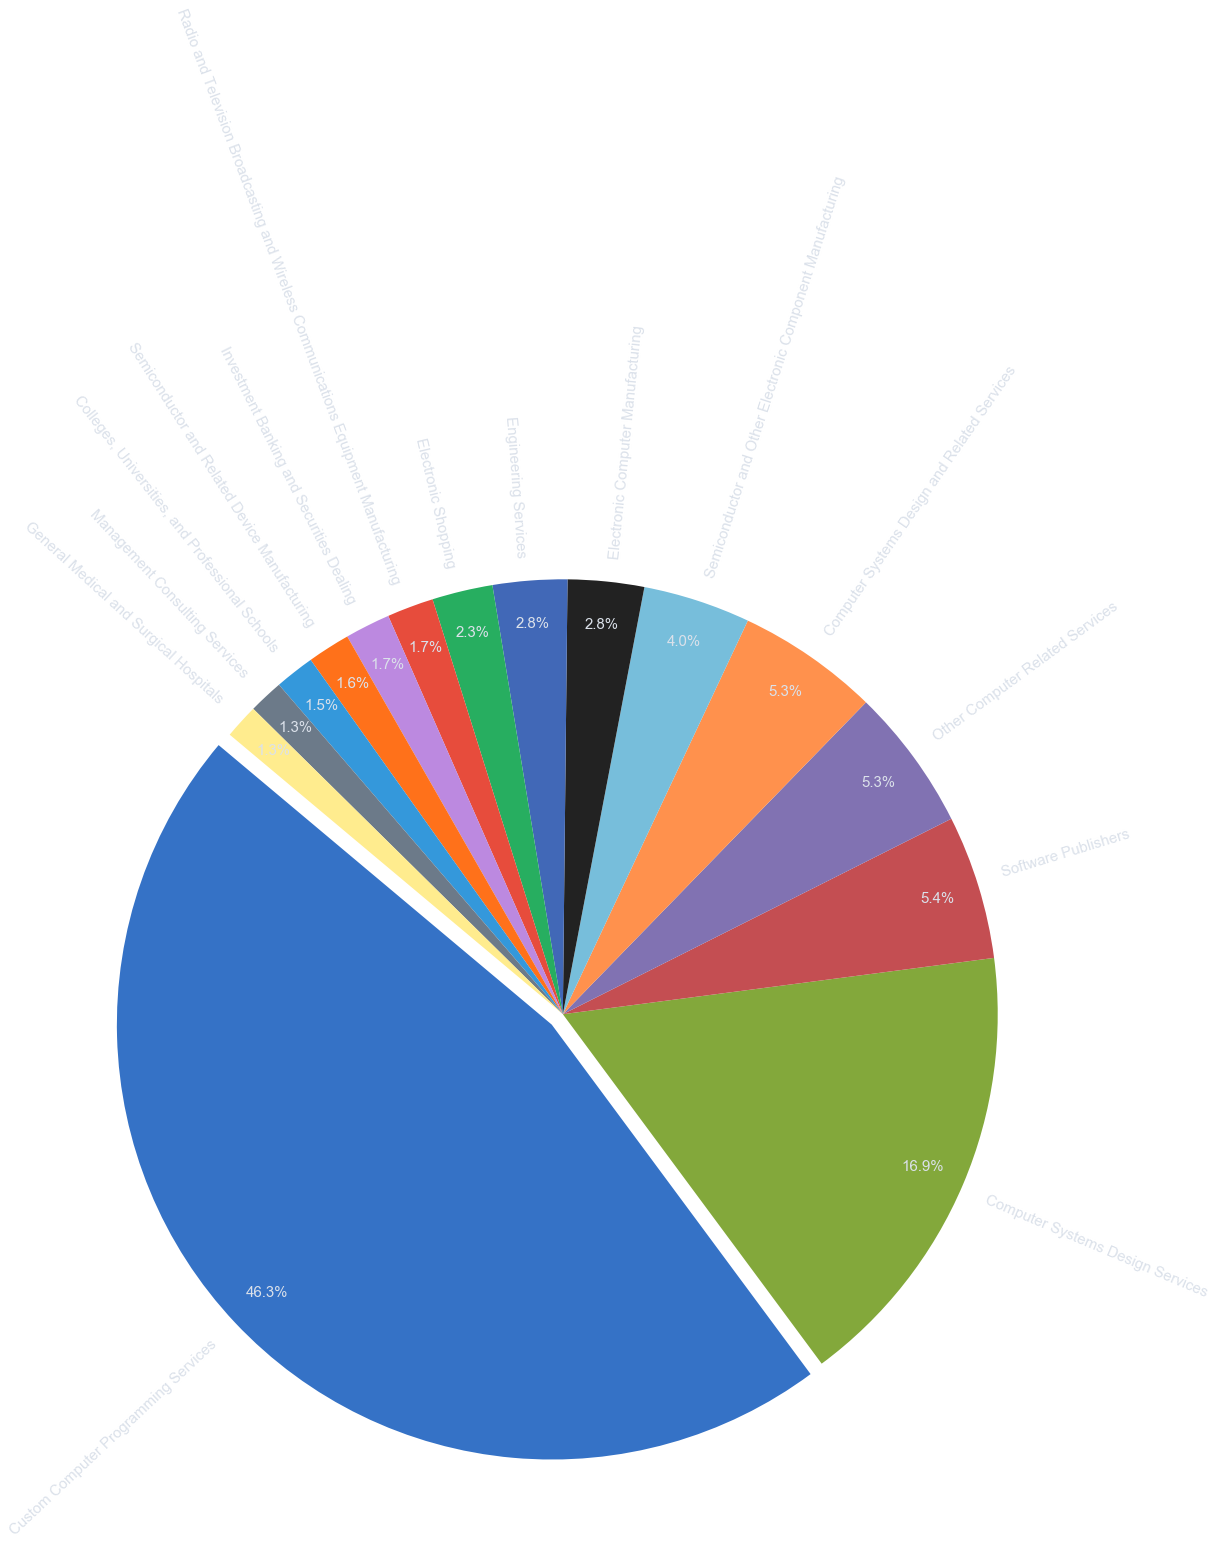

In [500]:
#Creating lists for us economic sectors and their counts
job_labels = []
job_values = []
explode = (0.035, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0)

for key, value in india_job_counts.items():
    job_labels.append(key)
    job_values.append(value)
    
#Setting plot parameters
plt.figure(figsize=(20,20))    
sb.set_context(rc={"font.size":15,"axes.labelsize":15,"xtick.labelsize" : 15})
plt.pie(job_values[:15], labels=job_labels[:15], explode = explode, autopct='%1.1f%%', pctdistance = 0.9,
          rotatelabels = 90, startangle=140, labeldistance = 1.05) 
# plt.savefig("output_data/images/top10jobfields.png", bbox_inches='tight')
plt.savefig("output/images/Indiatop15jobs.png", bbox_inches='tight')
# plt.savefig("output_data/images/top25jobfields.png", bbox_inches='tight')

In [440]:
# Highest paying employers
# emp_high_pay= certified_data.loc[(useful_data["pw_amount_9089"] > 150000), :]
# emp_high_pay['employer_name'].value_counts().loc[lambda x : x>9]
# emp_high_pay.sort_values("pw_amount_9089", ascending=False)

In [ ]:
#Create Data for flask app containing top 50 employers

In [285]:
top50emps = certified_data.employer_name.value_counts().iloc[:50].index
top50emps

Index(['Cognizant Technology Solutions Us Corporation',
       'Microsoft Corporation', 'Intel Corporation', 'Google Inc.',
       'Amazon Corporate Llc', 'Apple Inc.', 'Cisco Systems, Inc.',
       'Infosys Ltd.', 'Oracle America, Inc.', 'Deloitte Consulting Llp',
       'Qualcomm Technologies Inc.', 'Facebook, Inc.', 'Hcl America Inc.',
       'Yahoo! Inc.', 'Ernst & Young U.S. Llp', 'Jp Morgan Chase & Co',
       'Igate Technologies, Inc.', 'Wipro Limited', 'Ibm Corporation',
       'Broadcom Corporation', 'Ebay Inc.', 'Vmware, Inc.', 'Salesforce.Com',
       'Bloomberg L.P.', 'Capgemini Financial Services Usa Inc.',
       'Defender Services, Inc.', 'Randstad Technologies, Lp', 'Ericsson Inc.',
       'Cummins Inc.', 'Kforce Inc.', 'House Of Raeford Farms, Inc.',
       'Bank Of America', 'Pricewaterhousecoopers', 'Nvidia Corporation',
       'Paypal, Inc.', 'Emc Corporation',
       'Mastech, Inc., A Mastech Holdings, Inc. Company',
       'Linkedin Corporation', 'Wal-Mart Associa

In [286]:
topemp_data = certified_data[certified_data.employer_name.str.contains('|'.join(top50emps.array))]
topemp_data = topemp_data.reset_index(drop=True)

In [287]:
datedelta2 = topemp_data['decision_date'] - topemp_data['case_received_date']
topemp_data['decision_time'] = datedelta2.dt.days

In [289]:
output_data_file = "output/topemps_nans.csv"
topemp_data.to_csv(output_data_file)

In [290]:
topemp_data = topemp_data.dropna()
topemp_data = topemp_data.reset_index(drop=True)

In [292]:
output_data_file = "output/topemps.csv"
topemp_data.to_csv(output_data_file)

In [294]:
empindex = topemp_data.set_index('employer_name')

In [296]:
output_data_file = "output/topemps_index.csv"
empindex.to_csv(output_data_file)

In [295]:
empindex.head()

,case_received_date,case_status,decision_date,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,naics_us_title,year,salary,decision_time
employer_name,,,,,,,,,,,,,
Cognizant Technology Solutions Us Corporation,2013-11-13,Certified,2015-03-30,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,502.0
Cognizant Technology Solutions Us Corporation,2013-11-13,Certified,2015-03-30,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,502.0
Qualcomm Technologies Inc.,2013-12-03,Certified,2015-06-03,India,Master's,Master's,Boxborough,Massachusetts,122658.0,Radio and Television Broadcasting and Wireless...,2015,120-150k,547.0
Cognizant Technology Solutions Us Corporation,2013-11-14,Certified,2015-04-01,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,503.0
Cognizant Technology Solutions Us Corporation,2013-11-14,Certified,2015-04-01,India,Other,Bachelor's,College Station,Texas,54059.0,Computer Systems Design Services,2015,30-60k,503.0


In [293]:
topemp_data.head()

,case_received_date,case_status,decision_date,employer_name,country_of_citizenship,foreign_worker_info_education,job_info_education,job_info_work_city,job_info_work_state,pw_amount_9089,naics_us_title,year,salary,decision_time
0,2013-11-13,Certified,2015-03-30,Cognizant Technology Solutions Us Corporation,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,502.0
1,2013-11-13,Certified,2015-03-30,Cognizant Technology Solutions Us Corporation,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,502.0
2,2013-12-03,Certified,2015-06-03,Qualcomm Technologies Inc.,India,Master's,Master's,Boxborough,Massachusetts,122658.0,Radio and Television Broadcasting and Wireless...,2015,120-150k,547.0
3,2013-11-14,Certified,2015-04-01,Cognizant Technology Solutions Us Corporation,India,Bachelor's,Bachelor's,College Station,Texas,72467.0,Computer Systems Design Services,2015,60-90k,503.0
4,2013-11-14,Certified,2015-04-01,Cognizant Technology Solutions Us Corporation,India,Other,Bachelor's,College Station,Texas,54059.0,Computer Systems Design Services,2015,30-60k,503.0


# Machine Learning

In [38]:
# Pre-cleaning thoughts
#Displaying percentage of non-null values for each feature
i = 0;
for col in certified_data.columns:
    i = i+1;
    print (i-1,"Column: '{}'".format(col),"contains ", np.round(100*certified_data[col].count()/len(certified_data['case_status']),decimals=2),"% non-null values" )

0 Column: 'case_received_date' contains  65.51 % non-null values
1 Column: 'case_status' contains  100.0 % non-null values
2 Column: 'decision_date' contains  100.0 % non-null values
3 Column: 'employer_name' contains  100.0 % non-null values
4 Column: 'country_of_citizenship' contains  100.0 % non-null values
5 Column: 'foreign_worker_info_education' contains  65.51 % non-null values
6 Column: 'job_info_education' contains  65.51 % non-null values
7 Column: 'job_info_work_city' contains  100.0 % non-null values
8 Column: 'job_info_work_state' contains  100.0 % non-null values
9 Column: 'pw_amount_9089' contains  100.0 % non-null values
10 Column: 'naics_us_title' contains  99.38 % non-null values
11 Column: 'year' contains  100.0 % non-null values
12 Column: 'salary' contains  100.0 % non-null values


In [43]:
#dealing with Nans
nantest = certified_data.copy()
# nantest.loc[nantest['pw_soc_code'] == "None",'pw_soc_code'] = nantest['pw_soc_code'].mode()[0]
nantest['foreign_worker_info_education'] = nantest['foreign_worker_info_education'].fillna('Undisclosed')
# print(nantest['foreign_worker_info_education'].insa().sum())
nantest['foreign_worker_info_education'].value_counts()


Undisclosed    113980
Master's        95802
Bachelor's      81183
None            13824
Doctorate       11414
Other            9172
High School      3331
Associate's      1813
Name: foreign_worker_info_education, dtype: int64

In [131]:
#Since nans will make up the majority of values it is best to just remove the values completely... 
#however, mentioned before since only 3 columns suffer from NaNs will simply exclude those columns
drop_learn_data = useful_data.drop(['foreign_worker_info_education','job_info_education','case_received_date'], axis=1)
drop_learn_data.isna().sum()

case_status                  0
decision_date                0
employer_name                8
country_of_citizenship      41
job_info_work_city           5
job_info_work_state          6
pw_amount_9089              85
naics_us_title            4524
year                         0
salary                      85
dtype: int64

In [132]:
# Other NaN values make up <2% of column data, therefore will proceed with dropna
drop_learn_data = learn_data.dropna()
drop_learn_data.count()

case_status               351610
decision_date             351610
employer_name             351610
country_of_citizenship    351610
job_info_work_city        351610
job_info_work_state       351610
pw_amount_9089            351610
naics_us_title            351610
year                      351610
salary                    351610
dtype: int64

# Machine learning on case_status
Lets try to use machine learning to determine which attribute may hold biggest impact on having a case denied.
1. Clean Data
2. Pre-Processing
3. Model testing/selection
4. Importance
5. ?????
6. Profit

In [238]:
case_data = useful_data.dropna()
case_data = case_data.reset_index(drop=True)
case_data.count()

case_received_date               228769
case_status                      228769
decision_date                    228769
employer_name                    228769
country_of_citizenship           228769
foreign_worker_info_education    228769
job_info_education               228769
job_info_work_city               228769
job_info_work_state              228769
pw_amount_9089                   228769
naics_us_title                   228769
year                             228769
salary                           228769
dtype: int64

In [239]:
case_type ={'Certified': 1 , 'Denied': 0} 
case_data['case_status'] = case_data['case_status'].map(case_type)
# Copy warning with this code
# case_data.loc[case_data.case_status == 'Certified', 'case_status'] = 1
# case_data.loc[case_data.case_status == 'Denied', 'case_status'] = 0
case_data['case_status'].value_counts()

1    216385
0     12384
Name: case_status, dtype: int64

In [240]:
datedelta = case_data['decision_date'] - case_data['case_received_date']
case_data['decision_time'] = datedelta.dt.days

In [241]:
# can now drop date columns, along with year, can drop salary too
case_data = case_data.drop(['decision_date','case_received_date','salary','year'], axis=1)
case_data.count()

case_status                      228769
employer_name                    228769
country_of_citizenship           228769
foreign_worker_info_education    228769
job_info_education               228769
job_info_work_city               228769
job_info_work_state              228769
pw_amount_9089                   228769
naics_us_title                   228769
decision_time                    228769
dtype: int64

In [243]:
i = 0;
for col in case_data.columns:
    i = i+1;
    print (i-1,"Column: '{}'".format(col),"contains ",len(pd.unique(case_data[col])) ,"unique values" )

0 Column: 'case_status' contains  2 unique values
1 Column: 'employer_name' contains  48217 unique values
2 Column: 'country_of_citizenship' contains  193 unique values
3 Column: 'foreign_worker_info_education' contains  7 unique values
4 Column: 'job_info_education' contains  7 unique values
5 Column: 'job_info_work_city' contains  5515 unique values
6 Column: 'job_info_work_state' contains  57 unique values
7 Column: 'pw_amount_9089' contains  16734 unique values
8 Column: 'naics_us_title' contains  1478 unique values
9 Column: 'decision_time' contains  1934 unique values


In [ ]:
#may choose to come back and remove 'job_info_work_city' and reduce 'employer_name' if running into computation issues

In [244]:
case_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228769 entries, 0 to 228768
Data columns (total 10 columns):
case_status                      228769 non-null int64
employer_name                    228769 non-null object
country_of_citizenship           228769 non-null object
foreign_worker_info_education    228769 non-null object
job_info_education               228769 non-null object
job_info_work_city               228769 non-null object
job_info_work_state              228769 non-null object
pw_amount_9089                   228769 non-null float64
naics_us_title                   228769 non-null object
decision_time                    228769 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 17.5+ MB


# We may now begin Pre-processing

In [245]:
# Begin by encoding strings to int with sklearn preprocessing
from sklearn.preprocessing import LabelEncoder
categorical_variables = {}

#Creating categories denoted by integers from column values
for col in case_data.columns:
    cat_var_name = "cat_"+ col
    cat_var_name = LabelEncoder()
    cat_var_name.fit(case_data[col])
    case_data[col] = cat_var_name.transform(case_data[col])
    categorical_variables[col] = cat_var_name

case_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228769 entries, 0 to 228768
Data columns (total 10 columns):
case_status                      228769 non-null int64
employer_name                    228769 non-null int32
country_of_citizenship           228769 non-null int32
foreign_worker_info_education    228769 non-null int32
job_info_education               228769 non-null int32
job_info_work_city               228769 non-null int32
job_info_work_state              228769 non-null int32
pw_amount_9089                   228769 non-null int64
naics_us_title                   228769 non-null int32
decision_time                    228769 non-null int64
dtypes: int32(7), int64(3)
memory usage: 11.3 MB


In [248]:
#Dividing our final dataset into explanatory variables and target variable
X = case_data.loc[:, case_data.columns != 'case_status']
y = case_data.case_status

print("The shape of X is: {}".format(X.shape))
print("The shape of y is: {}".format(y.shape))

The shape of X is: (228769, 9)
The shape of y is: (228769,)


In [253]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

#Defining fit_algorithm function
def fit_algorithm(alg, X, y, parameters, cv = 5):
    """
    This function will split our dataset into training and testing subsets, fit cross-validated 
    GridSearch object, test it on the holdout set and return some statistics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)
    grid = GridSearchCV(alg, parameters, cv = cv)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    confmat = confusion_matrix(y_test,y_pred)

    return pd.Series({
        "Train_ACC": np.around(grid.best_score_, decimals=2).astype(str),
        "Test_ACC": np.around(grid.score(X_test, y_test), decimals=2).astype(str),
        "P": np.around(precision_score(y_pred, y_test), decimals=2).astype(str),
        "R": np.around(recall_score(y_pred, y_test),decimals=2).astype(str),
        "F1": np.around(f1_score(y_pred, y_test),decimals=2).astype(str),
        "Best_params": [grid.best_params_],
        "True negatives": confmat[0,0],
        "False negatives": confmat[1,0],
        "True positives": confmat[1,1],
        "False positives": confmat[0,1]
        })

# Try Logistic Regression model first
It is the go-to method for binary classification problems (problems with two class values). Which is perfect for case_status which is a 0 or 1.

In [254]:
from sklearn.linear_model import LogisticRegression
#To perform hyper parameter optimisation a list of multiple elements will be entered and the optimal 
#value in that list will be picked using Grid Search object
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }

logreg = fit_algorithm(LogisticRegression(solver='lbfgs', max_iter=7600),X,y,logreg_params)
logreg

Train_ACC                    0.95
Test_ACC                     0.95
P                             1.0
R                            0.95
F1                           0.97
Best_params        [{'C': 0.001}]
True negatives                428
False negatives               245
True positives              53866
False positives              2654
dtype: object

Logistic Rgression Classifier results in 95% accuracy on both test and train. 

# Try k-Nearest Neighbors
KNN assumes similarities exist in close porximity. Being a versatile model, it may yield better results.

In [255]:
#Importing k-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

#Defining range of parameters for kNN Clssifier
knn_params = {'n_neighbors': np.arange(1,11).tolist()}

#Using "fit_algorithm" function with kNN Classifier
knn = fit_algorithm(KNeighborsClassifier(),X,y,knn_params)
knn

Train_ACC                          0.95
Test_ACC                           0.96
P                                   1.0
R                                  0.96
F1                                 0.98
Best_params        [{'n_neighbors': 9}]
True negatives                      706
False negatives                     181
True positives                    53930
False positives                    2376
dtype: object

KNN yielded similar test/train accuracies, however has seen a slight 1% increase in F1 score, making it slightly more accurate than LR.

# Try Random Forest Classifier
With RFC, chances of making correct prodictions increase with number of uncorrelated trees in the model, based on the working dataset this could prove useful.

In [256]:
from sklearn.ensemble import RandomForestClassifier

#Defining range of parameters for Random Forest Clssifier
forest_params = {'n_estimators': [10,20,30,40,50],
     'max_depth': [15,20,25,30],
     'max_features': [2,3,4],
     'random_state': [123],
     'n_jobs': [-1]
    }

forest = fit_algorithm(RandomForestClassifier(),X,y, forest_params)
forest

Train_ACC                                                       0.96
Test_ACC                                                        0.96
P                                                               0.99
R                                                               0.97
F1                                                              0.98
Best_params        [{'max_depth': 25, 'max_features': 3, 'n_estim...
True negatives                                                  1374
False negatives                                                  305
True positives                                                 53806
False positives                                                 1708
dtype: object

As assumed RFC shows silghtly higher accuracies than previous models with a full 96% accuracy in both test and trains, however F1 remains the same as KNN even though Recall has seen a 1% improvement, Precision in turn sees a 1% disprovement.

# Try Gradient Boosted Regression
The main idea behind this algorithm is to combine multiple decision trees which in contrast to those used in RFC, are working in a serial manner, where each tree tries to correct the mistakes of the previous one. Assumption being, if RFC is the most accurate model, then GBR should squeeze out the final improvements.

In [257]:
#Importing GradientBoostingClassifier from sklearn
from sklearn.ensemble import GradientBoostingClassifier

#Defining range of parameters for Gradient Boosting Clssifier
gradient_params = {'n_estimators': [100],
     'max_depth': [3],
     'random_state': [123],
     'learning_rate': [0.1]
    }

gradient = fit_algorithm(GradientBoostingClassifier(),X,y,gradient_params)
gradient

Train_ACC                                                       0.96
Test_ACC                                                        0.96
P                                                               0.99
R                                                               0.96
F1                                                              0.98
Best_params        [{'learning_rate': 0.1, 'max_depth': 3, 'n_est...
True negatives                                                  1080
False negatives                                                  319
True positives                                                 53792
False positives                                                 2002
dtype: object

Unfortunately no improvement over RFC is seen, with an actual disprovement in Recall compared to RFC.

# Model Summary

In [261]:
# Dataframe made of results 
summary = pd.concat([logreg,knn,forest,gradient],axis=1)
summary.columns = ['Logistic Regression', 'k-Nearest Neighbors','Random Forest','GBoosted Machines']
summary = summary.drop('Best_params')
output_data_file = "output/MLsummary.csv"
summary.to_csv(output_data_file)
summary 

,Logistic Regression,k-Nearest Neighbors,Random Forest,GBoosted Machines
Train_ACC,0.95,0.95,0.96,0.96
Test_ACC,0.95,0.96,0.96,0.96
P,1.0,1.0,0.99,0.99
R,0.95,0.96,0.97,0.96
F1,0.97,0.98,0.98,0.98
True negatives,428,706,1374,1080
False negatives,245,181,305,319
True positives,53866,53930,53806,53792
False positives,2654,2376,1708,2002


# Test Importance
RFC determined to be most accurate model and to be used

In [270]:
# Conduct importance test based on most successful model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)
final_forest = RandomForestClassifier(n_estimators = 50, max_depth = 20, max_features = 4, random_state = 123, n_jobs = -1)
final_forest.fit(X_train, y_train)
importances = final_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

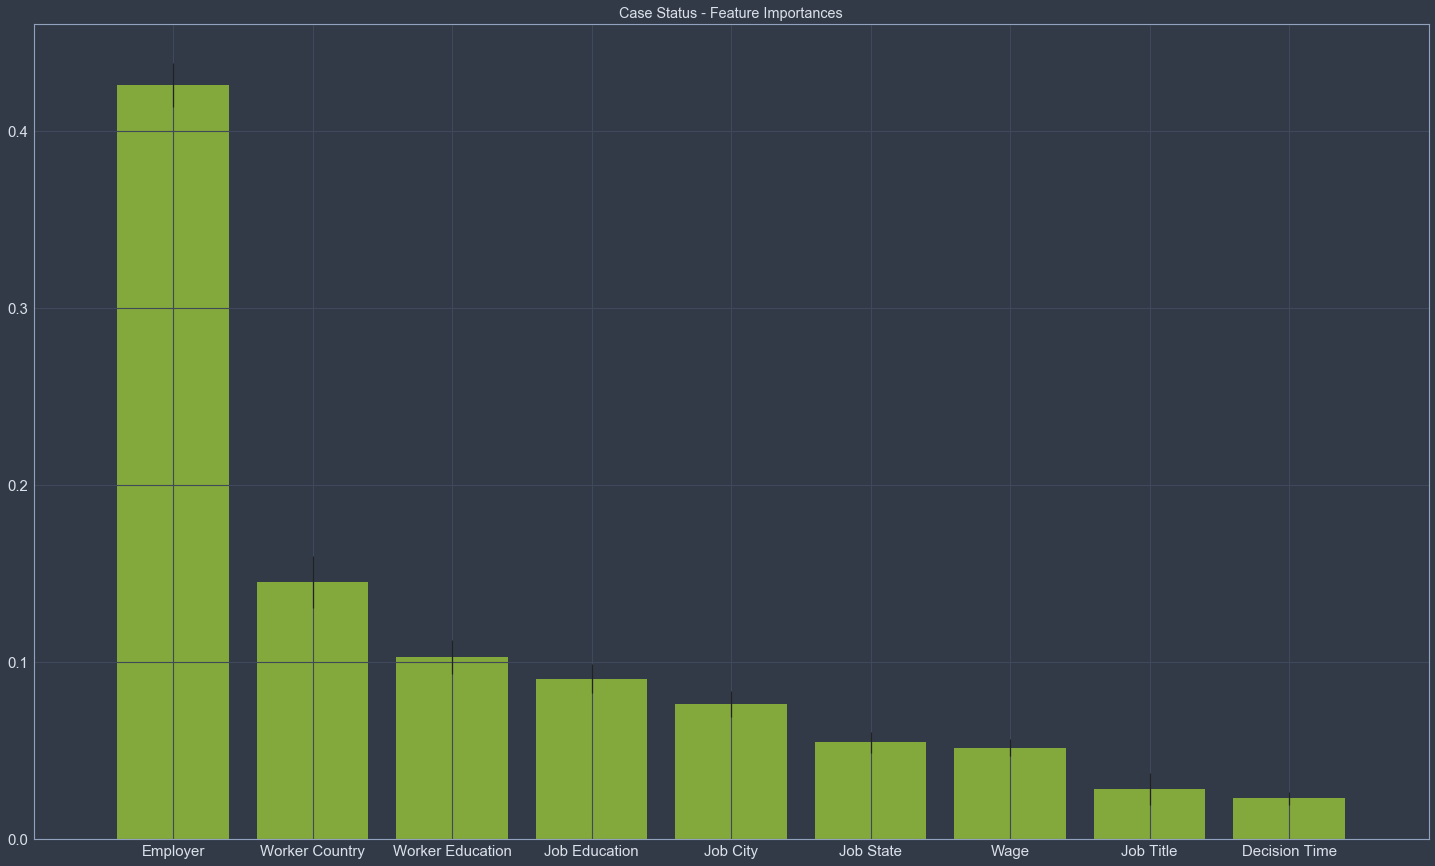

<Figure size 460.8x403.2 with 0 Axes>

In [302]:

plt.figure(figsize=(25, 15))
plt.title("Case Status - Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]),['Employer','Worker Country','Worker Education','Job Education','Job City','Job State','Wage','Job Title','Decision Time'])
plt.tick_params(labelsize=15)
plt.xlim([-1, X_train.shape[1]])
plt.show()  
plt.savefig("output/images/MLfeature.png")#, bbox_inches='tight')

It turns out the company that employs you is the most important factor in determining if your application will be successful or not. This is very interesting as this confirms that obtaining a US Visa depends on the legislative competency of the employer, and of course, which employer hires depends on the strength of the applicant. Moving onto other columns, country plays the second biggest factor, this may be due to different country relationships with the US. Afterwards Education is the third, this makes sense as previous analysis showed those with no education had the highest denial ratio. Another interesting fact is that job location holds more importance than wage and job title. Time of application holds the least importance on denial, meaning when you apply and wait long there is no need to panic. 

In [133]:
# Build another data set for education info which will have to drop 40% of rows
cert_edu_data=certified_data.dropna()
cert_edu_data.count()

case_received_date               216385
case_status                      216385
decision_date                    216385
employer_name                    216385
country_of_citizenship           216385
foreign_worker_info_education    216385
job_info_education               216385
job_info_work_city               216385
job_info_work_state              216385
pw_amount_9089                   216385
naics_us_title                   216385
year                             216385
salary                           216385
dtype: int64

In [134]:
cert_edu_data['salary'].value_counts().iloc[np.argsort(salary.index)]

0-30k       13369
30-60k      25678
60-90k      76609
90-120k     71744
120-150k    21281
150-180k     4957
180-210k     2256
210-240k      470
270k+           1
240-270k       20
Name: salary, dtype: int64

In [135]:
#Therefore can drop 270k+ salary as this value is an anomaly which will impede ML accuracy
cert_edu_data=cert_edu_data.loc[cert_edu_data['salary']!="270k+",:]
cert_edu_data['salary'].value_counts().iloc[np.argsort(salary.index)]

0-30k       13369
30-60k      25678
60-90k      76609
90-120k     71744
120-150k    21281
150-180k     4957
180-210k     2256
210-240k      470
270k+           0
240-270k       20
Name: salary, dtype: int64

In [136]:
cert_edu_data['receive_year'] = cert_edu_data['case_received_date'].dt.year
cert_edu_data = cert_edu_data.rename(columns={'year':'decision_year'})
cert_edu_data.count()

case_received_date               216384
case_status                      216384
decision_date                    216384
employer_name                    216384
country_of_citizenship           216384
foreign_worker_info_education    216384
job_info_education               216384
job_info_work_city               216384
job_info_work_state              216384
pw_amount_9089                   216384
naics_us_title                   216384
decision_year                    216384
salary                           216384
receive_year                     216384
dtype: int64

In [137]:
i = 0;
for col in cert_edu_data.columns:
    i = i+1;
    print (i-1,"Column: '{}'".format(col),"contains ",len(pd.unique(cert_edu_data[col])) ,"unique values" )

0 Column: 'case_received_date' contains  1597 unique values
1 Column: 'case_status' contains  1 unique values
2 Column: 'decision_date' contains  562 unique values
3 Column: 'employer_name' contains  44606 unique values
4 Column: 'country_of_citizenship' contains  191 unique values
5 Column: 'foreign_worker_info_education' contains  7 unique values
6 Column: 'job_info_education' contains  7 unique values
7 Column: 'job_info_work_city' contains  5224 unique values
8 Column: 'job_info_work_state' contains  57 unique values
9 Column: 'pw_amount_9089' contains  15953 unique values
10 Column: 'naics_us_title' contains  1456 unique values
11 Column: 'decision_year' contains  3 unique values
12 Column: 'salary' contains  9 unique values
13 Column: 'receive_year' contains  10 unique values


In [138]:
#High unique columns can be dropped with the exception of employer_name
#Name of employer will be crucial in predicting wages, therefore base dataset on top 50 employers
# top50emp=cert_edu_data['employer_name'].value_counts().loc[lambda x : x>9]
# # emp_high_pay= certified_data.loc[(useful_data["pw_amount_9089"] > 150000), :]
# # emp_high_pay['employer_name'].value_counts().loc[lambda x : x>9]
# # emp_high_pay.sort_values("pw_amount_9089", ascending=False)
# top50emp
topemps = cert_edu_data.employer_name.value_counts().iloc[:35].index
topemps
# topemps.array

Index(['Cognizant Technology Solutions Us Corporation',
       'Microsoft Corporation', 'Google Inc.', 'Intel Corporation',
       'Amazon Corporate Llc', 'Cisco Systems, Inc.', 'Apple Inc.',
       'Infosys Ltd.', 'Oracle America, Inc.', 'Facebook, Inc.',
       'Deloitte Consulting Llp', 'Hcl America Inc.',
       'Qualcomm Technologies Inc.', 'Wipro Limited', 'Yahoo! Inc.',
       'Ernst & Young U.S. Llp', 'Igate Technologies, Inc.',
       'Jp Morgan Chase & Co', 'Defender Services, Inc.',
       'House Of Raeford Farms, Inc.', 'Salesforce.Com',
       'Capgemini Financial Services Usa Inc.', 'Ibm Corporation',
       'Vmware, Inc.', 'Randstad Technologies, Lp', 'Cummins Inc.',
       'Bloomberg L.P.', 'Linkedin Corporation', 'Emc Corporation',
       'Case Farms Processing Inc.', 'Ericsson Inc.', 'Ebay Inc.',
       'Paypal, Inc.', 'Broadcom Corporation', 'Nvidia Corporation'],
      dtype='object')

In [139]:
# Setting up ML Prediction data
# Grab data that only contains top 35 employers
edu_ml_data = cert_edu_data[cert_edu_data.employer_name.str.contains('|'.join(topemps.array))]
# Drop string columns with numerous unique values, drop salary since 'pw_amount_9089' will be y
# Drop country_of_citizenship assuming no bias in hires based on country
edu_ml_data = edu_ml_data.drop(['decision_date','job_info_work_city','case_received_date','salary','country_of_citizenship'], axis=1)
edu_ml_data.count()

case_status                      50687
employer_name                    50687
foreign_worker_info_education    50687
job_info_education               50687
job_info_work_state              50687
pw_amount_9089                   50687
naics_us_title                   50687
decision_year                    50687
receive_year                     50687
dtype: int64

In [130]:
i = 0;
for col in edu_ml_data.columns:
    i = i+1;
    print (i-1,"Column: '{}'".format(col),"contains ",len(pd.unique(edu_ml_data[col])) ,"unique values" )

0 Column: 'case_status' contains  1 unique values
1 Column: 'employer_name' contains  35 unique values
2 Column: 'foreign_worker_info_education' contains  7 unique values
3 Column: 'job_info_education' contains  6 unique values
4 Column: 'job_info_work_state' contains  43 unique values
5 Column: 'pw_amount_9089' contains  4057 unique values
6 Column: 'naics_us_title' contains  32 unique values
7 Column: 'decision_year' contains  3 unique values
8 Column: 'receive_year' contains  7 unique values


In [ ]:
# In order to make a working predictor 

In [ ]:
#ML to predict wages using education included data

from sklearn.linear_model import LinearRegression

In [ ]:
#Dividing our final dataset into features(explanatory variables) and labels(target variable)
X = df.loc[:, df.columns != 'case_status']
y = df.case_status

print("The shape of X is: {}".format(X.shape))
print("The shape of y is: {}".format(y.shape))